In [3]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
from osgeo import gdal
import salem
from salem import *

import fiona, rasterio
import geopandas as gpd
from rasterio.plot import show
from rasterio.features import rasterize
from rasterstats import zonal_stats
from sklearn.metrics import mean_squared_error as MSE
import pwlf
import math
from scipy import stats
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm
import statsmodels.formula.api as smf
from hydroeval import *
import xarray as xr
import pickle

def cm2inch(*tupl):### plots in cm ##frontiers 180 mm for full width, 85 mm half width (1 column) figures
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
import warnings
warnings.filterwarnings("ignore")

years = [2016, 2017, 2018]
fl_path = '/home/pelto/Desktop/ice_flux/' + 'Conrad' + '/'
ZS_df_2016 = pd.read_csv(fl_path+'ZS_2016.csv')
ZS_df_2017 = pd.read_csv(fl_path+'ZS_2017.csv')
ZS_df_2018 = pd.read_csv(fl_path+'ZS_2018.csv')

sVSTAKE=1.10; sVOFFice=1.1; sVCoreg=2.0; sVRAND=1.5
sVsys=np.sqrt((sVOFFice**2)+(sVCoreg)**2)
sVZ=np.sqrt((sVsys**2)+((sVRAND)**2))
sVZ

2.7313000567495327

In [33]:
### Conrad ANOVA
stats.f_oneway(obs_fg_all,gpr_all),stats.f_oneway(obs_fg_all,opt_all) ,stats.f_oneway(obs_fg_all,farin_all) 

(F_onewayResult(statistic=0.14508569736761626, pvalue=0.7045999460528196),
 F_onewayResult(statistic=0.21898761798509062, pvalue=0.6414021099190068),
 F_onewayResult(statistic=0.3878269433870373, pvalue=0.5356566611895803))

VZ -ITS: 4.425793
VZ DIFF ratio: 0.24486627
nan
nan
Mean Vel. vz 18.07 13.67
Mean Vel. ITS 13.51 10.9
Original vector layer projection:  epsg:32611
New vector layer projection (PROJ4):  epsg:32611


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  epsg:32611
New vector layer projection (PROJ4):  epsg:32611


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')


No handles with labels found to put in legend.
No handles with labels found to put in legend.


2017
VZ -ITS: 7.141821
VZ DIFF ratio: 0.3783875
nan
nan
Mean Vel. vz 18.87 12.61
Mean Vel. ITS 11.69 9.25
Original vector layer projection:  epsg:32611
New vector layer projection (PROJ4):  epsg:32611


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  epsg:32611
New vector layer projection (PROJ4):  epsg:32611


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')


No handles with labels found to put in legend.
No handles with labels found to put in legend.


2018
VZ -ITS: 9.105841
VZ DIFF ratio: 0.47904924
nan
nan
Mean Vel. vz 19.01 12.85
Mean Vel. ITS 9.88 8.54
Original vector layer projection:  epsg:32611
New vector layer projection (PROJ4):  epsg:32611


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  epsg:32611
New vector layer projection (PROJ4):  epsg:32611


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')


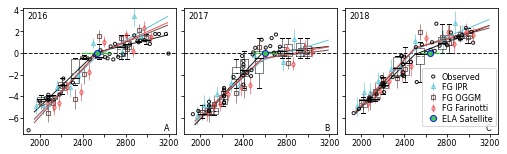

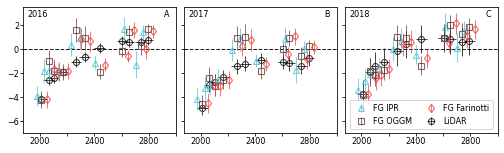

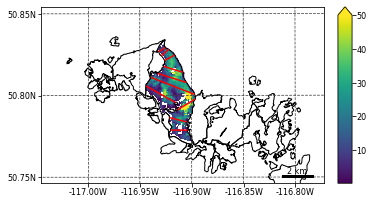

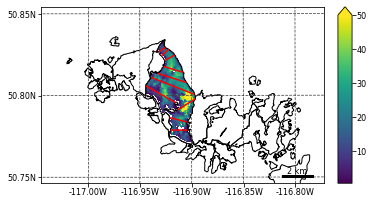

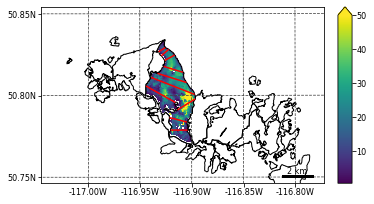

In [11]:
font = {'family' : 'Helvetica', 'weight' : 'normal',  'size'   : 8}
mfc='none'; mew=1.1; elw=0.9
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1.'; pylab.rcParams['ytick.major.pad']='1.'

fig1, ax1 = plt.subplots(1,3, sharex=True, sharey=True, figsize=(cm2inch(18, 5))) #obs. and flux gate SMB boxplot/errorbar plot
fig2, ax2 = plt.subplots(1,3, sharex=True, sharey=True, figsize=(cm2inch(18, 5))) ##mass conservation plot
count = 0

for yr in range(len(years)):
    # season
    balance = 'Ba'  # Bw or Ba (winter or annual)
    # rho_snow = 445. # 470 kg m-3 geodetic or 457 glaciological, or...take given years obs. value
    year = years[yr] # any of: 2016, 2017, 2018
    I = np.abs(year - 2016) # for selecting raster inputs

    gl = 1 # number to select glacier
    Glacier = ['Kokanee', 'Conrad', 'Illecillewaet',]
    glacier = ['kokanee', 'conrad', 'illecillewaet',]
#     d = 20. #20.  #distance (m) between flux gate points
    Dint = 0.85 #depth integrated velocity ratio, 1.0= all sliding
    sVSTAKE=1.10; sVOFFice=1.8; sVCoreg=3.0; sVRAND=2.0
    sVsys=np.sqrt((sVSTAKE**2)+(sVOFFice**2))
    sVZ=np.sqrt((sVsys**2)+(sVRAND**2))
    sHopt = 0.078 #10.2 ## ME:10.2 m,  MAE:0.223 (percent ratio) 0.16 is 2x the ME of Conrad, Illec, Kokanee
    cb = 6 ##center bin use this to assure flux in is from bins cb+1 and cb+2
    top =10 ## top bin

    fl_path = '/home/pelto/Desktop/ice_flux/' + Glacier[gl] + '/'
    gpr_path = '/home/pelto/GIS/GPR/ComparisonData/'
    path = '/home/pelto/Desktop/lidar_cbt_analysis/' + glacier[gl] + '/'

    VDIR = 'individual'  # 'average' or 'individual'
    ITS_LIVE = False
    firn = False
    fit='PW' # PW or 'LIN'
    
    if VDIR == 'individual':  

        vf_list = ['conrad_2016_vy_25m_pos.tif','conrad_2017_vy_25m_pos.tif','conrad_2018_vy_25m_pos_17mos.tif']
        vdir = '/home/pelto/Desktop/velocity_mapping/' +Glacier[gl] + '_DEMs/spm2/3m/'
        ITS = fl_path + 'ITS_Live/' + str(year) + '_conrad_ITS_LIVE.tif'
        if year == 2017:
            print(year)
            VX = vdir+ vf_list[I][:-14] + 'vx_25m.tif' 
            VY = vdir+ vf_list[I]
        if year == 2018:
            print(year)
            VX = vdir+ vf_list[I][:-20] + 'vx_25m.tif'
            VY = vdir+ vf_list[I]
        elif year == 2016:
            VX = vdir+ vf_list[I][:-14] + 'vx_25m.tif' 
            VY = vdir+ vf_list[I]
 
    else:
        vdir = '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/' #bedem5_spm2/'  
        VX = vdir+ 'conrad_all_3mdems+planet_25m_vx.tif' #'conrad_fast_vy.tif'
        VY = vdir+ 'conrad_all_3mdems+planet_25m_vy.tif' #'conrad_all_dem3m_vy_new_blur3_5m.tif'
        ITS = fl_path + 'ITS_Live/' + 'mosaic_conrad_ITS_LIVE.tif'
#     topo_list = ['140911_conrad_update_dem1_clip.tif', '20160912_conrad_dem1_clip_slave.tif', '20170917_conrad_dem1_clip_slave.tif']
    topo = path + '20160912_conrad_dem1_clip_slave.tif' #path + topo_list[I]
    
    farinotti = gpr_path + 'RGI60-02.02171_thickness.tif'

    dhW_list = ['conrad_2016_winter_dh_dt14s.tif', 'conrad_2017_winter_dh_dt16s.tif', 'conrad_2018_winter_dh_dt.tif']
    dhA_list = ['conrad_2015_2016_dh_dt_filled_1416+50cm.tif',  'conrad_2017_2016_dh_dt_17s14m.tif' ,'conrad_2018_2017_dh_dt.tif'] #'conrad_2016_2017_dh_dt+50cm.tif'
    if balance == 'Bw':
        dh_r = path+ dhW_list[I]   #winter height change TIFF
    else:
        dh_r = path+  dhA_list[I] #Annual height change TIFF
    
    SLOPE = '/home/pelto/GIS/DEM/Slope/ConradSlope160912_20m.tif'
    pts_file = fl_path + 'gis/conrad_bins_11_pts_25m_wgs84.shp'  #'conrad_points_17gates_C_20m_wgs84_b.shp'  # 'conrad_points_gates_20m_wgs84.shp'  ##must be WGS84
    gates = fl_path+'conrad_flux_gates_new11.shp'  #'conrad_flux_gates_17_C.shp' #conrad_flux_gates_17_C    conrad_flux_gates
    shpf = path + Glacier[gl] + '/conrad_all_glaciers_2014.shp'  #GLIMS_BC/glims_all/all_glaciers_2016.shp' 
    bins=fl_path+'gis/conrad_bins_11_2016.shp' #'_bins_2017_C'+'.shp' #_bins_2017_C  _bins
    obs = pd.read_csv(fl_path+ 'Conrad_bdot.csv') 
    rho = pd.read_csv(fl_path + 'RHO.csv')  ## MUST MATCH NUMBER OF BINS  conrad_rho_new11.csv
    
    # open GeoTIFFs as arrays
    vy = salem.open_xr_dataset(VY);vy = vy.to_array(name='vy')
    vx = salem.open_xr_dataset(VX);vx = vx.to_array(name='vx')
    msk = salem.open_xr_dataset('/home/pelto/Desktop/lidar_cbt_analysis/conrad/conrad_total_msk.tif') 
    msk_conrad = salem.open_xr_dataset('/home/pelto/Desktop/lidar_cbt_analysis/conrad/conrad_2014_extent_5m.tif')

    gpr = salem.open_xr_dataset(fl_path + 'gpr_25_100m_5m.tif') #'gpr_outlines_all_25_25m_re5m.tif'
    farin = salem.open_xr_dataset(farinotti)

    H_opt = salem.open_xr_dataset(fl_path+'Conrad_opt_thick_final.tif')  #'opt_thick_251sw.tif') 
    gates = salem.read_shapefile(gates)
    
    gpr_reproj = vy.salem.transform(gpr);gpr = gpr_reproj.to_array(name='gpr')
    slope=salem.open_xr_dataset(SLOPE);slope_reproj = vy.salem.transform(slope)
    slope = slope_reproj.to_array(name='slope')
    
    msk_reproj = vy.salem.transform(msk)  #note succeeding trying to use gdalwarp to go from 2955 --> 32611
    msk = msk_reproj.to_array(name='msk')
    msk_conrad_reproj = vy.salem.transform(msk_conrad);msk_conrad = msk_conrad_reproj.to_array(name='msk_conrad')

    ITS = salem.open_xr_dataset(ITS); ITS_reproj = vy.salem.transform(ITS);ITS = ITS_reproj.to_array(name='ITS')
    
    # farin = farin.to_array(name='vx')
    H_opt_reproj = vy.salem.transform(H_opt);H_opt = H_opt_reproj.to_array(name='H_opt')

    farin_reproj= vy.salem.transform(farin);farin = farin_reproj.to_array(name='farin')
    srtm_corr = fl_path + 'conrad_SRTM_diff_30m.tif'
    srtm_corr = salem.open_xr_dataset(srtm_corr)
    srtm_corr = vy.salem.transform(srtm_corr)
    srtm_corr = srtm_corr.to_array(name='srtm_corr')
    srtm_corr.data[srtm_corr.data>10.0] = 0.0  ##remove positive anomalous values
    srtm_corr.data[srtm_corr.data<-50.0] = 0.0 ##remove negative anomalous values
    farin_corr = farin + srtm_corr; farin_corr= farin_corr.rename('farin_corr')
    
    gpr.data[gpr.data<0.5] = np.nan; # no data on file set to zero,
    slope.data[slope.data<0.0]=np.nan
    
    vy.data[vy.data<0.01]=np.nan
    vz = vy; vz.data = np.sqrt(vx.data**2 + vz.data**2 )
    vz.data[msk_conrad.data!=1.0] = np.nan;ITS.data[msk_conrad.data!=1.0] = np.nan;
    vz=xr.DataArray(vz.data, coords=vz.coords, name='vz')
#     np.savetxt(), vz[0].data, delimiter=',')
    
    with open(fl_path+str(year)+'_vz.pkl', 'wb') as f:
        pickle.dump(vz[0].data, f)
    with open(fl_path+str(year)+'_ITS.pkl', 'wb') as f:
        pickle.dump(ITS[0].data, f)
#     vx.data[msk.data==0] = np.nan;vy.data[msk.data==0] = np.nan;VZ[msk_conrad.data<0.0] = np.nan 
    VZ_off_ice = vz.copy(); VZ_off_ice.data[msk.data==1.0] = np.nan  
       
    DIFF = vz - ITS
    print("VZ -ITS:", np.nanmean(DIFF)); print("VZ DIFF ratio:", np.nanmean(DIFF)/np.nanmean(vz))
    dh = salem.open_xr_dataset(dh_r); dh_reproj = vy.salem.transform(dh); dh = dh_reproj.to_array(name='dh')#dh.data[dh.data<1] = np.nan
    
    dem = salem.open_xr_dataset(topo);dem_reproj = vy.salem.transform(dem); dem = dem_reproj.to_array(name='dem')
    dem.data[dem.data<1] = np.nan
    
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(cm2inch(18, 8.25))) 
    grid = vy.salem.grid  ##full view
    sm = Map(grid, countries=False)
    sm.set_lonlat_contours(interval=0)
    sm.set_scale_bar()
    sm.set_data(vz) #, label='m')
    sm.set_vmax(val=50.)
    #      Change the lon-lat countour setting
    sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
    off_ice_V = np.nanmean(VZ_off_ice)
    print(off_ice_V)
    print(np.nanstd(VZ_off_ice))
    print('Mean Vel. vz', round(np.nanmean(vz),2), round(np.nanstd(vz),2))
    print('Mean Vel. ITS', round(np.nanmean(ITS),2), round(np.nanstd(ITS),2))
    gdf = salem.read_shapefile(shpf)
    sm.set_shapefile(gdf, linewidth=1)
    sm.set_shapefile(gates, linewidth=1.5, color='r')
    sm.visualize()
#     fig.savefig(fl_path+ 'products/'+ glacier[gl] + str(year) +'_thickness_gates_diff.png', dpi=300)
#     fig.show()

    ## Functions for calculating zonal statistics over each flux gate bin
    # https://community.esri.com/groups/python-snippets/blog/2019/05/07/calculating-zonal-statistics-with-python-rasterstats
    # For loading shapefiles into geopandas dataframe

    def enum_items(source):
        print("\n")
        for ele in enumerate(source): 
            print(ele)

    def list_columns(df):
        field_list = list(df)
        enum_items(field_list)
        return field_list

    def loadshp_as_gpd(shp):
        data_shp = gpd.read_file(shp)
        return data_shp

    # For loading feature classes into geopandas dataframe
    def loadfc_as_gpd(fgdb):
        layers = fiona.listlayers(fgdb)
        enum_items(layers)
        index = int(input("Which index to load? "))
        fcgpd = gpd.read_file(fgdb,layer=layers[index])
        return fcgpd

    # For re-projecting input vector layer to raster projection
    def reproject(fcgpd, raster):
        proj = raster.crs.to_proj4()
        print("Original vector layer projection: ", fcgpd.crs)
        reproj = fcgpd.to_crs(proj)
        print("New vector layer projection (PROJ4): ", reproj.crs)
#         fig, ax = plt.subplots(figsize=(15, 15))
#         rplt.show(raster, ax=ax)
#         reproj.plot(ax=ax, facecolor='none', edgecolor='red')
#         fig.show()
        return reproj

    def dissolve_gpd(df):
        field_list = list_columns(df)
        index = 1 #int(input("Dissolve by which field (index)? "))
        dgpd = df.dissolve(by=field_list[index])
        return dgpd

    # For selecting which raster statistics to calculate
    def stats_select():
        stats_list = stats_list = ['min', 'max', 'mean', 'count', 
                  'sum', 'std', 'median', 'majority', 
                  'minority', 'unique', 'range']
        enum_items(stats_list)
    #     indices = input("Enter raster statistics selections separated by space: ")
        indices='2 3 5 6'
        stats  = list(indices.split())
        out_stats = list()
        for i in stats:
            out_stats.append(stats_list[int(i)])
        return out_stats

    def get_zonal_stats(vector, raster, stats):
        # Run zonal statistics, store result in geopandas dataframe
        result = zonal_stats(vector, raster, stats=stats, geojson_out=True)
        geostats = gpd.GeoDataFrame.from_features(result)
        return geostats

    ## make an ice velocity quiver plot
#     fig, ax = plt.subplots(1,1,figsize=(10,10))
    df = salem.read_shapefile(pts_file) 
    df_file = loadshp_as_gpd(pts_file)
#     df_file.crs

    coords = np.array([p.xy for p in df.geometry]).squeeze()
    df['lon'] = coords[:, 0]; df['lat'] = coords[:, 1]

    # ax.scatter(df.lon, df.lat, s=10, c='r' )#c='depth',cmap='viridis', s=10, ax=ax);
    xx, yy = salem.transform_proj(salem.wgs84, grid.proj, df['lon'].values, df['lat'].values)
    df['x'] = xx; df['y'] = yy

    # shp_plt = reproject(df, VX)

    X, Y = np.meshgrid(vx.coords['x'],vx.coords['y'])
    U = vx.data[0]; V = vy.data[0]

    vns = ['vx','vy','vz', 'ITS', 'gpr','H_opt','dem','farin_corr','dh','slope']

    M = xr.merge([vx,vy,vz,ITS,gpr,H_opt,dem,farin_corr,dh,slope])

    for vn in vns:
        df[vn] = M[vn][0].interp(x=('z', df.x), y=('z', df.y))

    df_agg = df[['ID', 'len', 'distance', 'angle', 'geometry', 'lon', 'lat']].copy()
    ii, jj = grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
    df_agg['i'] = ii; df_agg['j'] = jj
    # # We trick by creating an index of similar i's and j's
    df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
    df_agg = df_agg.groupby('ij').mean()

    # Select
    for vn in vns:
        df_agg[vn] = M[vn][0].isel(x=('z', df_agg.i), y=('z', df_agg.j))  
    df_test = df_agg.copy()
    #add in missing IPR data
    D = df_agg[['ID', 'len', 'distance', 'angle', 'lon', 'lat', 'vx', 'vy', 'vz','ITS', 'gpr', 'slope','H_opt', 'dem', 'farin_corr']].copy()  
    D['vzdir'] = np.arcsin(D.vx/D.vz) *180/math.pi #degrees from north
    
    if VDIR == 'individual':
        # fill any missing vel. direction
        for i in range(len((D))):   
            if np.isnan(D.vzdir[i])==True:
                G=D.ID[i];V=np.nanmedian(D.vzdir[D.ID==G]) 
                D.vzdir[i]=V

        ## fill in velocity nans at edges (sometimes 1-2 nan pts at edge due to mask res.)
        for i in range(D.ID.nunique()):
            d=D[(D.ID==i)&(D.distance<230)]
            dist=d.distance[np.isnan(d.vz)].values; 
            x=d.distance[np.logical_not(np.isnan(d.vz))].values;y=d.vz.values; y=y[np.logical_not(np.isnan(y))]
            coefficients = np.polyfit(x, y, 1); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
            new_y = poly(new_x);fill=poly(dist);#plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
        for f in range(len(dist)):
            D.vz[(D.ID==i)&(D.distance==dist[f])]=fill[f]

            d=D[(D.ID==i)&(D.distance>(D.len - 100))]
            dist=d.distance[np.isnan(d.vz)].values; 
            x=d.distance[np.logical_not(np.isnan(d.vz))].values;y=d.vz.values; y=y[np.logical_not(np.isnan(y))]
            coefficients = np.polyfit(x, y, 1); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
            new_y = poly(new_x);fill=poly(dist);#plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
            for f in range(len(dist)):
                D.vz[(D.ID==i)&(D.distance==dist[f])]=fill[f] 

    ### fill ice thickness gaps 
    #last and first points in each line are zero depth (except gate 7 end, gates 6, 8, 9 start)
    D.distance[(D.ID==0)&(D.distance==511.4)]=522.8
    D.gpr[D.distance==0.0]=0.0;D.gpr[(D.distance==D.len)]=0.0;
    D.gpr[(D.ID==8)&(D.distance==0.0)]=np.nan;D.gpr[(D.ID==9)&(D.distance==0.0)]=np.nan;
    D.gpr[(D.ID==7)&(D.distance==D.len)]=np.nan;D.gpr[(D.ID==6)&(D.distance==0.0)]=np.nan;D.gpr[(D.ID==6)&(D.distance==D.len)]=np.nan
    
    D.H_opt[(D.gpr==0.0)&(D.distance==0.0)]=0.0;D.H_opt[(D.gpr==0.0)&(D.distance==D.len)]=0.0;
    D.farin_corr[(D.gpr==0.0)&(D.distance==0.0)]=0.0;D.farin_corr[(D.gpr==0.0)&(D.distance==D.len)]=0.0;
        
    ## start with gates where left bound is not bedrock
    d=D[(D.ID==8)&(D.distance<200)];dist=d.distance[np.isnan(d.gpr)].values;
    x=d.distance[np.logical_not(np.isnan(d.gpr))].values;y=d.gpr.values; y=y[np.logical_not(np.isnan(y))]
    coefficients = np.polyfit(x, y, 2); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist);#plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.ID==8)&(D.distance==dist[f])]=fill[f]

    d=D[(D.ID==8)&(D.distance>350)&(D.distance<700)];dist=d.distance[np.isnan(d.gpr)].values;
    x=d.distance[np.logical_not(np.isnan(d.gpr))].values;y=d.gpr.values; y=y[np.logical_not(np.isnan(y))]
    coefficients = np.polyfit(x, y, 2); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist);#plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.ID==8)&(D.distance==dist[f])]=fill[f]

    d=D[(D.ID==8)&(D.distance>700)];dist=d.distance[np.isnan(d.gpr)].values;
    x=d.distance[np.logical_not(np.isnan(d.gpr))].values;y=d.gpr.values; y=y[np.logical_not(np.isnan(y))]
    coefficients = np.polyfit(x, y, 2); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist);#plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.ID==8)&(D.distance==dist[f])]=fill[f]
    
    d=D[(D.ID==9)&(D.distance>800)];dist=d.distance[np.isnan(d.gpr)].values;
    x=d.distance[np.logical_not(np.isnan(d.gpr))].values;y=d.gpr.values; y=y[np.logical_not(np.isnan(y))]
    coefficients = np.polyfit(x, y, 4); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist)#;plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.ID==9)&(D.distance==dist[f])]=fill[f]
     
    d=D[(D.ID==0)];dist=d.distance[np.isnan(d.gpr)].values;
    x=d.distance[np.logical_not(np.isnan(d.gpr))].values;y=d.gpr.values; y=y[np.logical_not(np.isnan(y))]
    coefficients = np.polyfit(x, y, 6); poly = np.poly1d(coefficients);new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist);#plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.ID==0)&(D.distance==dist[f])]=fill[f]
        
    d=D[(D.ID==1)];dist=d.distance[np.isnan(d.gpr)].values;
    x=d.distance[np.logical_not(np.isnan(d.gpr))].values;y=d.gpr.values; y=y[np.logical_not(np.isnan(y))]
    coefficients = np.polyfit(x, y, 5); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist)#;plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.ID==1)&(D.distance==dist[f])]=fill[f]

    d=D[(D.ID==2)];dist=d.distance[np.isnan(d.gpr)].values;
    x=d.distance[np.logical_not(np.isnan(d.gpr))].values;y=d.gpr.values; y=y[np.logical_not(np.isnan(y))]
    coefficients = np.polyfit(x, y, 6); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist)#;plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.ID==2)&(D.distance==dist[f])]=fill[f]
        
    d=D[(D.ID==3)];dist=d.distance[np.isnan(d.gpr)].values;
    x=d.distance[np.logical_not(np.isnan(d.gpr))].values;y=d.gpr.values; y=y[np.logical_not(np.isnan(y))]
    coefficients = np.polyfit(x, y, 8); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist);#plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.ID==3)&(D.distance==dist[f])]=fill[f]
        
    d=D[(D.ID==4)];dist=d.distance[np.isnan(d.gpr)].values;
    x=d.distance[np.logical_not(np.isnan(d.gpr))].values;y=d.gpr.values; y=y[np.logical_not(np.isnan(y))]
    coefficients = np.polyfit(x, y, 6); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist);#plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.ID==4)&(D.distance==dist[f])]=fill[f]
    
    d=D[(D.ID==5)&(D.distance<1400)];dist=d.distance[np.isnan(d.gpr)].values;
    x=d.distance[np.logical_not(np.isnan(d.gpr))].values;y=d.gpr.values; y=y[np.logical_not(np.isnan(y))]
    coefficients = np.polyfit(x, y, 3); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist);#plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.ID==5)&(D.distance==dist[f])]=fill[f]
        
    d=D[(D.ID==7)];dist=d.distance[np.isnan(d.gpr)].values;#&(D.distance<500)
    x=d.distance[np.logical_not(np.isnan(d.gpr))].values;y=d.gpr.values; y=y[np.logical_not(np.isnan(y))]
    coefficients = np.polyfit(x, y, 7); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist);#plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.ID==7)&(D.distance==dist[f])]=fill[f]
        
    D_all=D.copy()
    if ITS_LIVE == True:
        D['vfg'] = D.ITS
    else:
        #multiply velocity vector by cosine of angle between vector and flux gate (line or line segment)
        D['vfg'] = np.abs(D.vz * np.cos((D.vzdir-(D.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice
#     D.to_csv(fl_path+ glacier[gl]+ 'D_test.csv')
    for i in range(len((D))):   #D.ID.nunique()):
        if np.isnan(D.vfg[i])==True:
            G=D.ID[i]
            V=np.nanmean(D.vfg[D.ID==G]) 
            D.vfg[i]=V
    with open(fl_path + str(year)+'_Dvfg.pkl', 'wb') as f:
        pickle.dump(D.vfg.values, f)
        
##### correct ice thickness for thinning ##############  
    DH=[]
    D1=D.copy(); D1.reset_index(inplace=True,drop=True);DH=[]
    for i in range(len(D1)):
        fl_id=D1.loc[i].ID
        if year == 2016:
            del_h = 0.0
        elif year == 2017:
            del_h=new16.loc[fl_id].dh_mean
        elif year == 2018:
            del_h=new17.loc[fl_id].dh_mean
        DH.append(del_h)
    D['DH']=DH #used to correct ice thickness for surface height change due to mass loss
    D.H_opt = D.H_opt + D.DH
    D.H_opt[D.H_opt<0.] = 0.0
    D.gpr = D.gpr + D.DH 
    D.gpr[D.gpr<0.] = 0.0
    D.farin_corr = D.farin_corr + D.DH
    D.farin_corr[D.farin_corr<0.] = 0.0
##### end correct ice thickness for thinning ############## 

    D.sort_values(by=['distance','ID'],ascending=[True,True], inplace=True) 
    
    for n in range(D.ID.nunique()):

        for c in range(len(D.ID[D.ID==n])): #.count()-1)#range(D.ID[D.ID==n].count()-1):
            idx=D[(D.ID==n)&(D.distance==D[D.ID==n].distance[c])].index

            if c==0:  ## first point in line
                L= D.distance[D.ID==n][c+1] - D.distance[D.ID==n][c]
                G= L * D.H_opt[D.ID==n][c+1]*0.5;J= L * D.farin_corr[D.ID==n][c+1]*0.5 #area of triangle
            elif c==1: #second point from start
                L= (D.distance[D.ID==n][c+1] - D.distance[D.ID==n][c])/2
                G= L * D.H_opt[D.ID==n][c]; J= L * D.farin_corr[D.ID==n][c]
            elif c==len(D.ID[D.ID==n])-2: #second to last point
                L= (D.distance[D.ID==n][c] - D.distance[D.ID==n][c-1])/2 
                G= L * D.H_opt[D.ID==n]; J= L * D.farin_corr[D.ID==n]
            elif c==len(D.ID[D.ID==n])-1:  #last point in line
                L= (D.distance[D.ID==n][c] - D.distance[D.ID==n][c-1])
                G= L * D.H_opt[D.ID==n][c-1]*0.5; J= L * D.farin_corr[D.ID==n][c-1]*0.5 #area of triangle
            else:
                L=(((D.distance[D.ID==n][c+1]-D.distance[D.ID==n][c])/2) + ((D.distance[D.ID==n][c] -
                        D.distance[D.ID==n][c-1])/2))
                G=L* D.H_opt[D.ID==n][c] ; J=L* D.farin_corr[D.ID==n][c]  
                
            D.loc[idx,'A_Hopt']= G;D.loc[idx,'A_farin']= J; D.loc[idx,'Len_mod']= L     
    D_all=D.copy()
    D['Qopt'] = D.A_Hopt * (D.vfg) * Dint;D['Qfarin'] = D.A_farin * (D.vfg) * Dint    

    ### Uncertainties
    D['sQout'] = np.sqrt((sVZ * D.A_Hopt)**2 + ((D.vfg*Dint) * D.Len_mod * (sHopt*D.H_opt))**2)
    D['sQout_low'] = np.sqrt((sVZ * D.A_Hopt)**2 + ((D.vfg*0.80) * D.Len_mod * (sHopt*D.H_opt))**2)
    D['sQout_high'] = np.sqrt((sVZ * D.A_Hopt)**2 + ((D.vfg*1.00) * D.Len_mod * (sHopt*D.H_opt))**2)
    D['sQoutF'] = np.sqrt((sVZ * D.A_farin)**2 + ((D.vfg*Dint) * D.Len_mod * (sHopt*D.farin_corr))**2)

    Q_out= [0.,] #flux out per gate
    cr_area = [0.,] # cross-section area per gate
    vzdir = [0.,]; sQout= [0.,];sQout_low= [0.,];sQout_high= [0.,];vfg_all=[];gate_elev=[];v_gate_mean=[0.,];
    GPR=[0.,];HF=[0.,];Hopt=[0.,];gate_width=[0.,];Len_mod=[0.,];
    DV= D.copy(); DV = DV.dropna(subset=['vfg'])
    
    for n in range(D.ID.nunique()):
        vfg_all.append(DV.vfg[DV.ID==n]);gate_elev.append(D.dem[D.ID==n].mean())
        
####### calculate flux per bin by summing slices #######
    for n in range(D.ID.nunique()+1):
            Q_out.append(D.Qopt[D.ID==n].sum()) ;cr_area.append(D.A_Hopt[D.ID==n].sum())
            vzdir.append(D.vzdir[D.ID==n].mean())
            sQout.append(D.sQout[D.ID==n].sum());sQout_low.append(D.sQout_low[D.ID==n].sum()); sQout_high.append(D.sQout_high[D.ID==n].sum()) 
            v_gate_mean.append(D.vfg[D.ID==n].mean());Hopt.append(D.H_opt[D.ID==n].mean())
            gate_width.append(D.len[D.ID==n].max()); Len_mod.append(D.Len_mod[D.ID==n].sum())
            GPR.append(D.gpr[D.ID==n].mean())
    Q_in = [Q_out[1:]]; sQin = [sQout[1:]+ [0.0]] ##1.0 instead of zero to prevent uncertainty nan
    sQin_low = [sQout_low[1:]+ [0.0]];sQin_high = [sQout_high[1:]+ [0.0]]    
    Q_in = np.squeeze(Q_in);sQin = np.squeeze(sQin);sQin_low = np.squeeze(sQin_low);sQin_high = np.squeeze(sQin_high)
    

    Q_outF= [0.,] #flux out per gate
    cr_areaF = [0.,]; sQoutF = [0.,]
    for n in range(D.ID.nunique()+1):
            Q_outF.append(D.Qfarin[D.ID==n].sum()) ;cr_areaF.append(D.A_farin[D.ID==n].sum()) 
            sQoutF.append(D.sQoutF[D.ID==n].sum());     HF.append(D.farin_corr[D.ID==n].mean())

    Q_inF = [Q_outF[1:]] #flux in per bin
    Q_inF = np.squeeze(Q_inF);sQinF = [sQoutF[1:]+ [0.0]]; sQinF = np.squeeze(sQinF)

    FG = pd.DataFrame(list(zip(Q_out, Q_in, cr_area, sQout, sQout_low, sQout_high, sQin, sQin_low, sQin_high, Q_outF, Q_inF, sQoutF, sQinF, cr_areaF, vzdir, 
           v_gate_mean, gate_width,GPR,Hopt, HF,Len_mod)), columns=['Q_out', 'Q_in', 'cr_area', 'sQout', 'sQout_low', 'sQout_high', 'sQin', 'sQin_low', 'sQin_high','Q_outF', 'Q_inF',
            'sQoutF', 'sQinF', 'cr_areaF', 'vzdir', 'v_gate_mean','gate_width','gpr','Hopt','HF','Len_mod']) 

    FG.loc[cb, 'Q_in'] = FG.Q_out[cb+1]+ FG.Q_out[cb+2] ## Q_in for cb (center bin)
    FG.loc[cb, 'Q_inF'] = FG.Q_outF[cb+1]+ FG.Q_outF[cb+2] ## Q_in for cb (center bin)
    FG.loc[(cb+1), 'Q_in'] = 0.0  ## set Q_in to zero (one to prevent uncertainty nan) for top of west wing
    FG.loc[(cb+1), 'Q_inF'] = 0.0  ## set Q_in to zero (one to prevent uncertainty nan) for top of west wing
    
    FG['vel_fg'] = FG.Q_out / FG.cr_area #net velocity per gate
    FG['vel_fgF'] = FG.Q_outF / FG.cr_area
    FG['bin']=np.arange(0,len(range(D.ID.nunique()+1)),1)
    # FG['sQnet_opt'] = np.sqrt(FG.sQopt**2 + FG.sQin**2)

    FG['spQout'] = FG.sQout / FG.Q_out * 100. #%err on flux
    FG['spQin'] = FG.sQin / FG.Q_in * 100. #%err on flux
    FG['spQoutF'] = FG.sQoutF / FG.Q_outF * 100. #%err on flux
    FG['spQinF'] = FG.sQinF / FG.Q_inF * 100. #%err on flux

    ### import data per bin: height change, elevation, surface area, obs.SMB etc. 

    FG_df = FG.copy(); dem_r = topo;vel_r = VY; shp = loadshp_as_gpd(bins)

    rasters = [dh_r, dem_r]; names = ['dh','dem'] #, vel_r,SLOPE  ,'vy','slope'
    for i in range(len(rasters)):
        raster = rasters[i]; rst = rasterio.open(raster); shp = reproject(shp, rst) #shp is in correct projection, trying anyway for calculation
        name = names[i]
        stat = stats_select()  #'['min', 'max', 'mean', 'count', 'sum', 'std', 'median', 'majority', 'minority', 'unique', 'range']
        ZS = (get_zonal_stats(shp, raster, stat))
        ZS.drop(['geometry'], axis=1, inplace=True)
        ZS.rename(columns={"mean": name+"_mean", "median":name+"_med", "std": name+"_std", "count":name+"_count"}, inplace=True)
        ZS.sort_values(by=['bin'],ascending=True, inplace=True)
        ZS.set_index('bin', inplace=True)
        FG_df =  pd.concat([FG_df, ZS], axis=1)

    rho.sort_values(by='bin',ascending=True, inplace=True) # sort by bin
    rho.set_index('bin', inplace=True) # set bin as index for sorting
    FG_df =  pd.concat([FG_df, rho], axis=1)

    WR= np.array(FG_df.dem_count[1:])
    WR= np.append(WR,[0]) # calculate area of flux in (area of bin above a given bin)

    FG_df['Q_net'] = FG_df.Q_in - FG_df.Q_out  #net flux per gate
    FG_df['Q_netA']= FG_df.Q_net / FG_df.dem_count
    FG_df['Q_netF'] = FG_df.Q_inF - FG_df.Q_outF  #net flux per gate
    FG_df['Q_netAF']= FG_df.Q_netF / FG_df.dem_count

    FG_df['area_Qin']= WR
    FG_df.loc[cb, 'area_Qin'] = FG_df.dem_count[cb+1]+ FG_df.dem_count[cb+2]

    FG_df['sQoptA'] = FG_df.sQout / FG_df.dem_count
    FG_df['sQoptA_low'] = FG_df.sQout_low / FG_df.dem_count;FG_df['sQoptA_high'] = FG_df.sQout_high / FG_df.dem_count    
    FG_df['sQ_inA'] = FG_df.sQin / (FG_df.area_Qin+0.001)
    FG_df['sQ_inA_low'] = FG_df.sQin_low / (FG_df.area_Qin+0.001);FG_df['sQ_inA_high'] = FG_df.sQin_high / (FG_df.area_Qin+0.001)
    FG_df['sQnetA_opt'] = np.sqrt(FG_df.sQoptA**2 + FG_df.sQ_inA**2)
    FG_df['sQnetA_opt_low'] = np.sqrt(FG_df.sQoptA_low**2 + FG_df.sQ_inA_low**2);FG_df['sQnetA_opt_high'] = np.sqrt(FG_df.sQoptA_high**2 + FG_df.sQ_inA_high**2)

    FG_df['sQoutFA'] = FG_df.sQoutF / FG_df.dem_count
    FG_df['sQ_inFA'] = FG_df.sQinF / (FG_df.area_Qin+0.001)
    FG_df['sQnetFA'] = np.sqrt(FG_df.sQoutFA**2 + FG_df.sQ_inFA**2)

    ##calculate height change due to mass balance for highest bins considering firn compaction
    if firn == False:
        FG_df.Vfirn = 0.00
    if year==2017:
        FG_df.loc[top, 'dh_mean'] = -0.78 # correct top bin dh for void, took median of highest avail. data
    if year==2018:
        FG_df.loc[top-1, 'dh_mean'] = 0.55
        FG_df.loc[top, 'dh_mean'] = 0.62
    FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA + FG_df.Vfirn
    FG_df['b_fg_hF'] = FG_df.dh_mean - FG_df.Q_netAF + FG_df.Vfirn
    FG_df.column_depth = FG_df.column_depth * FG_df.firn_area ## adjust firn column height for firn area
    FG_df['RHO'] = ((FG_df.column_density * FG_df.column_depth) + (910. * (FG_df.Hopt-FG_df.column_depth)))/ FG_df.Hopt
    FG_df['RHO_F'] = ((FG_df.column_density * FG_df.column_depth) + (910. * (FG_df.HF-FG_df.column_depth)))/ FG_df.HF 
    FG_df.loc[0, 'RHO'] = 910.;FG_df.loc[0, 'RHO_F'] = 910.
    
    if balance == 'Bw':
        FG_df['b_fg_we'] = FG_df.rho_snow/1000 * FG_df.b_fg_h
        FG_df['b_fg_weF'] = FG_df.rho_snow/1000 * FG_df.b_fg_hF
    else:
        FG_df['b_fg_we'] = FG_df['RHO']/1000. * FG_df.b_fg_h           #FG_df['rho_%s'%year]/1000. * FG_df.b_fg_h
        FG_df['b_fg_weF'] = FG_df['RHO_F']/1000. * FG_df.b_fg_hF

    ### Uncertainties
    #sDHdt = 0.21 #0.04 #m Bias dh from Pelto et al. 2019
    if I==0:
        sDHdt = 0.21 #NMAD from Pelto et al. 2019
    if I==1:
        sDHdt = 0.31
    elif I==2:
        sDHdt = 0.59
    sVfirn = 0.10; sRHO = 0.10 #0.05 # percent uncertainty in density

    FG_df['sDH_opt'] = np.sqrt(sDHdt**2 + (FG_df.sQnetA_opt)**2 + (FG_df.Vfirn*sVfirn)**2)
    FG_df['sBwe_opt'] = np.sqrt((FG_df.sDH_opt * (FG_df['RHO']/1000.))**2+
                   (FG_df.b_fg_h * (FG_df['RHO']/1000.*sRHO))**2)

    FG_df['sDH_F'] = np.sqrt(sDHdt**2 + (FG_df.sQnetFA)**2 + (FG_df.Vfirn*sVfirn)**2)
    FG_df['sBwe_F'] = np.sqrt((FG_df.sDH_F * (FG_df['RHO_F']/1000.))**2+
                   (FG_df.b_fg_hF * (FG_df['RHO_F']/1000.*sRHO))**2)

    D['Agpr']=np.NaN;D.gpr[D.len==0.]=np.nan;  #D.gpr[D.ID==6]=np.nan;
    D.gpr[(D.ID==6)]=0.0 ## &(D.distance==0.0)temp. add false point to avoid instability
    D = D.dropna(subset=['gpr']); D.sort_values(by=['distance','ID'],ascending=[True,True], inplace=True) 

    for n in range(D.ID.nunique()):

        for c in range(len(D.ID[D.ID==n])): #.count()-1)#range(D.ID[D.ID==n].count()-1):
            idx=D[(D.ID==n)&(D.distance==D[D.ID==n].distance[c])].index
            if c==0:  ## first point in line
                L= D.distance[D.ID==n][c+1] - D.distance[D.ID==n][c]
                G= L * D.gpr[D.ID==n][c+1]*0.5;J= L * D.farin_corr[D.ID==n][c+1]*0.5 #area of triangle         
            elif c==1: #second point from start
                L= (D.distance[D.ID==n][c+1] - D.distance[D.ID==n][c])/2
                G= L * D.gpr[D.ID==n][c]; J= L * D.farin_corr[D.ID==n][c]
            elif c==len(D.ID[D.ID==n])-2: #second to last point
                L= (D.distance[D.ID==n][c] - D.distance[D.ID==n][c-1])/2 
                G= L * D.gpr[D.ID==n]; J= L * D.farin_corr[D.ID==n]
            elif c==len(D.ID[D.ID==n])-1:  #last point in line
                L= (D.distance[D.ID==n][c] - D.distance[D.ID==n][c-1])
                G= L * D.gpr[D.ID==n][c-1]*0.5; J= L * D.farin_corr[D.ID==n][c-1]*0.5 #area of triangle
            else:
                L=(((D.distance[D.ID==n][c+1]-D.distance[D.ID==n][c])/2) + ((D.distance[D.ID==n][c] -
                        D.distance[D.ID==n][c-1])/2))
                G=L* D.gpr[D.ID==n][c] ; J=L* D.farin_corr[D.ID==n][c]  
                
            D.loc[idx,'Agpr']= G; D.loc[idx,'Len_gpr']= L 

    #calculate flux out using GPR thicknesses
    sGPR = 0.10 #0.0516 #gpr error %
    D['sInterp_gpr'] = np.nan
    for n in range(len(D.Len_gpr)):
        if D.Len_gpr[n] > 50.:
            D.sInterp_gpr[n] = D.gpr[n] * 0.10  
        else: 
            D.sInterp_gpr[n] = 0.0
    sH_gpr = np.sqrt(D.sInterp_gpr**2+ (D.gpr*sGPR)**2)

    D['Qo_gpr'] = D.Agpr * (D.vfg) * Dint#* 0.9
    D['sQo_gpr'] =  np.sqrt((sVZ * (D.gpr) * D.Len_gpr)**2 + ((D.vfg*Dint) * D.Len_gpr * (sH_gpr))**2)
    Qo_gpr = [0.,] #flux out per gate
    cr_area_gpr = [0.,] # cross-section area per gate
    vzdir_gpr = [0.,];  sQo_gpr= [0.,]; Len_gpr=[0.,]
    for n in range(D.ID.nunique()):  #for n in D.ID.unique(): the ID's are out of order here
            Qo_gpr.append(D.Qo_gpr[D.ID==n].sum()) ;  cr_area_gpr.append(D.Agpr[D.ID==n].sum())
            vzdir_gpr.append(D.vzdir[D.ID==n].mean()); sQo_gpr.append(D.sQo_gpr[D.ID==n].sum())
            Len_gpr.append(D.Len_gpr[D.ID==n].sum());  Qin_gpr = [Qo_gpr[1:]+ [0.0]] #flux in per bin, add zero to end for top bin 
    Qin_gpr = np.squeeze(Qin_gpr); sQin_gpr = [sQo_gpr[1:]+ [0.0]]; sQin_gpr = np.squeeze(sQin_gpr)

    FG_gpr = pd.DataFrame(list(zip(Qo_gpr, Qin_gpr, cr_area_gpr, sQo_gpr,sQin_gpr,Len_gpr)), 
                          columns=['Qo_gpr', 'Qin_gpr', 'cr_area_gpr', 'sQo_gpr','sQin_gpr','Len_gpr']) 
    FG_gpr['bin'] = np.arange(0,len(range(D.ID.nunique()+1)),1)#[0,1,2,3]

    FG_gpr.loc[cb+1, 'Qo_gpr'] = FG_df.Q_out[cb+1] #flux out for top of west wing, which has no radar measurements
    FG_gpr.loc[cb, 'Qin_gpr'] = FG_gpr.Qo_gpr[cb+1]+ FG_gpr.Qo_gpr[cb+2] #flux in for center bin
    FG_gpr.loc[(cb+1), 'Qin_gpr'] = 0.0  ## set Q_in to zero for top of west wing
    
    FG_gpr['spQo_gpr'] = FG_gpr.sQo_gpr / FG_gpr.Qo_gpr * 100. #%err on flux
    FG_gpr['spQin_gpr'] = FG_gpr.sQin_gpr / FG_gpr.Qin_gpr * 100. #%err on flux

    FG_all = FG_df.merge(FG_gpr, how='left') #on='bin')  
    FG_all['Q_net_gpr'] = FG_all.Qin_gpr - FG_all.Qo_gpr 

    FG_all['Q_netA_gpr']= FG_all.Q_net_gpr / FG_all.dem_count 
    FG_all.loc[cb+1, 'Q_netA_gpr'] = np.nan # no flux est for bin without IPR measurements
    FG_all['b_fg_h_gpr'] = FG_all.dh_mean - FG_all.Q_netA_gpr+ FG_all.Vfirn #dh1516_mean
    FG_all.loc[cb+1, 'b_fg_h_gpr'] = np.nan # SMB for top of west wing, which has no radar measurements
    FG_all['sQoutA_gpr'] = FG_all.sQo_gpr / FG_all.dem_count
    FG_all['sQ_inA_gpr'] = FG_all.sQin_gpr / (FG_all.area_Qin+0.001)
    FG_all['sQnetA_gpr'] = np.sqrt(FG_all.sQoutA_gpr**2 + FG_all.sQ_inA_gpr**2)
    FG_all['RHO_g'] = ((FG_all.column_density * FG_all.column_depth) + (910. * (FG_all.gpr-FG_all.column_depth)))/ FG_all.gpr; 
    FG_all.loc[0, 'RHO_g'] = 910.
    if balance == 'Bw':
        FG_all['b_fg_we_gpr'] = FG_df.rho_snow/1000. * FG_all.b_fg_h_gpr
    else:
        FG_all['b_fg_we_gpr'] = FG_all['RHO_g']/1000. * FG_all.b_fg_h_gpr
    
    #FG_all.loc[len(FG_gpr)-1,'b_fg_we_gpr'] = np.nan #no radar data available for flux calculation for top bin
    
    FG_all['sDH_gpr'] = np.sqrt(sDHdt**2 + (FG_all.sQnetA_gpr)**2 + (FG_all.Vfirn*sVfirn)**2)
    FG_all['sBwe_gpr'] = np.sqrt((FG_all.sDH_gpr * (FG_all['RHO_g']/1000.))**2+
                   (FG_all.b_fg_h_gpr * (FG_all['RHO_g']/1000.*sRHO))**2)

    n = 0;    a = 0.7; s= 10 #markersize
    obs=obs[(obs.Year==year)]; obs.reset_index(inplace=True)

    obs = obs.dropna(subset=['Ba'])
    y_ax_obs=obs[(obs.Year==year)].Ba;  x_ax_obs=obs[(obs.Year==year)].Elev

    new = FG_all.copy();#new.drop([7],inplace=True);new.reset_index(inplace=True)
    
    yerr = [0.0, new.sBwe_gpr, new.sBwe_opt, new.sBwe_F] #new.sBwe_gpr
    new['xerr'] = new.dem_std * 1.5 #2 std dev -- 95% of data
    xerr = new.xerr 
  
    x_ax_fg_gpr=new.dem_med;y_ax_fg_gpr=new.b_fg_we_gpr
    x_ax_fg_opt=new.dem_med;y_ax_fg_opt=new.b_fg_we;x_ax_fg_F=new.dem_med ;y_ax_fg_F=new.b_fg_weF
    x = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt, x_ax_fg_F]
    y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt, y_ax_fg_F]
    
    letter=['A','B','C']
    color = ['k', '#51c2d5','#663f3f','#ec4646'] #'teal', '#74c476', '#238b45']
#     label = ['Obs.', 'Fg IPR', 'Fg OGGM','Farinotti']
    label=['Observed', 'FG IPR', 'FG OGGM', 'FG Farinotti']
    sym = ['o', '^', 's', 'd']
    # Call function to create error bars 
    shift = [-50,0,50]
    ax1[count].scatter(x[0],y[0],color=color[0], label=label[0], alpha=a+.2, s=s,facecolor='', zorder=3)
    for i in range(3):
        ax1[count].errorbar((x[i+1]+shift[i]), y[i+1], xerr=None, yerr=yerr[i+1], fmt=sym[i+1], ecolor=color[i+1], zorder=2,
                              label=label[i+1], alpha=0.8, mfc=mfc, mew=mew, c=color[i+1], ms=4, elinewidth=0.7) #elinewidth=0.7

        ## plot data and regression lines
    ytxt = [0.2, 0.15, 0.1, 0.05]     
    txt= ['Observed', 'FG IPR     ', 'FG OGGM   ', 'FG Farinotti']

    if balance == 'Ba':
        ax1[count].axhline(linewidth=1, color='k', ls='--', alpha=a+.2, zorder=0)
        ax2[count].axhline(linewidth=1, color='k', ls='--', alpha=a+.2, zorder=0)

    ############ obs data box plot ################
    obs_data=obs[(obs.Year==year)]; obs_data.reset_index(inplace=True)
    if year == 2017:
        obs_data[balance]= obs_data[balance]-0.32 ## GPS survey correction between LiDAR 9-17-2017 and field 9-8-2017
    bin_size = 100.; z_range = np.arange(1950., 3250., bin_size)
    i = 0; Z_F = []; Zor_F= []; OB_F=[]

    for z in z_range: 
        W=0;bin_size = 100.; COU=1
        while W==0:
            OBS = [];Z = [];Zor = [];
            for n in range(len(obs_data[balance])):
                if ((z - bin_size/2.) <= obs_data.Elev[n]) and (obs_data.Elev[n] <=  (z + bin_size/2.)):
                    O = obs_data[balance][n]
                    Z.append(z);Zor.append(obs_data.Elev[n]);OBS.append(O)
            if len(OBS)<2:
                bin_size=bin_size*(1+(.2*COU))
                COU=COU+1
            else:
                OB_F.append(np.array(OBS)); Z_F.append(np.array(Z));  Zor_F.append(np.array(Zor))
                W=1
        i += 1
        
##################Difference###########################################################
       
    GPR = [];OPT = [];FAR = []  
    for z in z_range:
        W=0; COU=1;bin_size = 100.
        while W==0:
            GG=[];PP=[];FF=[]
            ####collect balance values for each elevation bin
            for n in range(len(new.dem_mean)): #for n in new.bin:  # 
                if ((z - bin_size/2.) <= new.dem_mean[n]) and (new.dem_mean[n] <=  (z + bin_size/2.)):
                    G = new.b_fg_we_gpr[n]
                    P = new.b_fg_we[n]
                    F = new.b_fg_weF[n]
                    GG.append(G);FF.append(F);PP.append(P)
            GG=np.array(GG)
            GG = GG[np.logical_not(np.isnan(GG))]
            if len(GG)<1:
                bin_size=bin_size*(1+(0.1*COU))
                COU=COU+1
            else:
                GPR.append(GG);OPT.append(np.array(PP));FAR.append(np.array(FF))
                W=1

    if count == 0:
        gpr_bdiff=[];opt_bdiff=[];farin_bdiff=[];z_range_all=[];obs_all=obs_data;obs_bin_all=[];gpr_all=[];
        opt_all=[];farin_all=[];elev_all=[];elev_gpr_all=[];gpr_bin_all=[];opt_bin_all=[];farin_bin_all=[];
        NSE=[];PBias=[];RSR=[];RSQ=[];SE=[];SL=[];ME=[];MAE=[];MSE_ABL=[];MSE_ACC=[];MSE_ALL=[];RLM_SL=[];
        RLM_SE=[];SL_L=[];SE_L=[];RSQ_L=[];gpr_bd_fg=[];opt_bd_fg=[];farin_bd_fg=[];obs_fg_all=[];ELA_pw=[];ELA_lin=[]
      
    ###### bfinned observations for each flux bin ##############
    OB_FG=[];OB_FG_h=[]
    for i in range(len(new.dem_mean)): 
        f = new.dem_mean[i]
        W=0;bin_size = new.dem_std[i]*2; COU=1
        while W==0:
            OBSFG = []; OBSFGh=[]
            for n in range(len(obs_data[balance])):
                if ((f - bin_size) <= obs_data.Elev[n]) and (obs_data.Elev[n] <=  (f + bin_size)):
                    O = obs_data[balance][n]
                    Oh= obs_data['Ba_h'][n]
                    OBSFG.append(O);OBSFGh.append(Oh)
            if len(OBSFG)<3:#and bin_size<175:
                bin_size=bin_size*(1+(.2*COU))
                COU=COU+1
            else:
                OB_FG.append(np.array(OBSFG));OB_FG_h.append(np.array(OBSFGh));
                W=1
    
    ##### boxplot of observations ######
    meanlineprops = dict(linestyle='--', linewidth=1., color='0.5'); medianprops = dict(linestyle='-', linewidth=1, color='k')
    boxprops = dict(linewidth=0.5);
    BOX=ax1[count].boxplot(OB_FG,meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,sym='',
                    positions=new.dem_med,widths=75,boxprops=boxprops,whiskerprops=boxprops)
    
    OBF=[];GPRq=[];OPTq=[];FARq=[];OB_FGmean=[];OB_FG_hmean=[]
    ###calculate mean of balance values within each elevation bin
    for i in range(len(OB_F)):
        OBF.append(np.round(OB_F[i].mean(),3));GPRq.append(np.round(GPR[i].mean(),3))
        OPTq.append(np.round(OPT[i].mean(),3));FARq.append(np.round(FAR[i].mean(),3))
    for i in range(len(OB_FG)): ##OBS means for each FG bin
        OB_FGmean.append(np.round(OB_FG[i].mean(),3));OB_FG_hmean.append(np.round(OB_FG_h[i].mean(),3))
    
    FG_all['OB_FG']=OB_FGmean
    FG_all.dropna(subset=['b_fg_we_gpr'], inplace=True)  ## remove data for bins where GPR is nan 
    
    obs_fg_all.extend(OB_FGmean);obs_bin_all.extend(OBF);gpr_bin_all.extend(GPRq);opt_bin_all.extend(OPTq);farin_bin_all.extend(FARq);z_range_all.extend(z_range) ##all binned data
    elev_gpr_all.extend(FG_all.dem_mean);gpr_all.extend(FG_all.b_fg_we_gpr);opt_all.extend(new.b_fg_we);
    farin_all.extend(new.b_fg_weF);elev_all.extend(new.dem_mean) ## all point and gate data
       
    gpr_bdiff.extend((np.array(OBF) - np.array(GPRq))); 
    opt_bdiff.extend((np.array(OBF) - np.array(OPTq))); farin_bdiff.extend((np.array(OBF) - np.array(FARq)))
    
    gpr_bd_fg.extend((np.array(OB_FGmean) - np.array(new.b_fg_we_gpr)))#; gpr_bd_fg.extend([np.nan,np.nan])
    opt_bd_fg.extend((np.array(OB_FGmean) - np.array(new.b_fg_we))); farin_bd_fg.extend((np.array(OB_FGmean) - np.array(new.b_fg_weF)))
    
############## piecewise function ########################################         
#     y_bin=[OBF,GPRq[:-2],OPTq,FARq]; x_bin=[z_range,z_range[:-2],z_range,z_range]
    
    y_bin=[OB_FGmean,FG_all.b_fg_we_gpr, new.b_fg_we,new.b_fg_weF]; x_bin=[new.dem_med,FG_all.dem_med,new.dem_med,new.dem_med]
    bp = [2525,2575,2500] # break point (~ELA)
    ELA = [2530,2600,2645];    s_ELA = [135,110,90]
    def piecewise_linear(x, x0, y0, k1, k2):
        x0=bp[I]
        return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])   
    
    for i in range(4):     
        x0=bp[I];Y=np.array(y_bin[i]);  X=np.array(x_bin[i])
        p , e = curve_fit(piecewise_linear, X, Y )
        xd = np.arange(1950., 3200., 10.); yd = piecewise_linear(xd, *p)
        
        ## get the slope
        model = pwlf.PiecewiseLinFit(xd, yd)
        breaks = model.fit_guess([x0]); #breakpoints = [2150.,x0,2900.]
        sl=model.slopes; se=model.standard_errors(); rsq=model.r_squared()
        SL.append(sl);RSQ.append(rsq)
        #x_hat = np.linspace(2150, 2900, 10);  y_hat = model.predict(x_hat) 
        ela = (0.0 - model.intercepts[0]) / sl[0]; ELA_pw.append(ela)
        if fit == 'PW':
            ax1[count].plot(xd, piecewise_linear(xd, *p), color=color[i], lw=1., alpha=0.9)#0.9
#         X=np.array(y_bin[i]);  Y=np.array(x_bin[i])

######## calc SE ######
        model1 = pwlf.PiecewiseLinFit(X, Y)
        breakpoints1 = [1950,x0,3300]
        model1.fit_with_breaks(breakpoints1);se=model1.standard_errors();SE.append(se);
#######################
  
        x1=np.array(x_bin[i]); y1=np.array(y_bin[i])

        # mean square error of the lines
        for Line in range(2):
            Pred=[];Act=[]
            if Line ==0:
                INDEX= np.where(x1<x0)[0]
                for ix in INDEX:
                    Pred.append( p[2]*x1[ix]+(p[1]-p[2]*x0))
                    Act.append(y1[ix])
                MSE_ABL.append(MSE(Act,Pred))
            if Line==1:
                INDEX= np.where(x1>=x0)[0]
                for ix in INDEX:
                    Pred.append( p[3]*x1[ix]+(p[1]-p[3]*x0))
                    Act.append(y1[ix])
                MSE_ACC.append(MSE(Act,Pred))
########## Linear fit ##################                
    for i in range(4): 
        Y=np.array(y_bin[i]);X=np.array(x_bin[i])
        model = pwlf.PiecewiseLinFit(X, Y)
        breakpoints = [1950.,3300.]
        model.fit_with_breaks(breakpoints)
        x_hat = np.linspace(1950, 3120, 10); y_hat = model.predict(x_hat)
        if fit == 'LIN':
            ax1[count].plot(x_hat, y_hat, lw=1.1, alpha=a, color=color[i], zorder=1)#label=label[i])
        sll=model.slopes; sel=model.standard_errors(); rsql=model.r_squared()
        SL_L.append(sll);SE_L.append(sel);RSQ_L.append(rsql)
        x1=np.array(x_bin[i]); y1=np.array(y_bin[i])
        p , e = curve_fit(piecewise_linear, x1, y1 )
        xd = np.arange(1950., 3150., 10.)
        ela = (0.0 - model.intercepts[0]) / sll[0]; ELA_lin.append(ela)

########################### end piecewise ################################
    ## add ELA to plot                 
    ax1[count].errorbar(ELA[I],0., xerr=s_ELA[I], yerr=None, fmt='o', c='limegreen', mec='b',
            mfc='limegreen',mew=mew, elinewidth=elw+0.4, label='ELA Satellite', alpha=0.85, zorder=4)   
    
    ax1[count].set(xlim=(1845,3270), ylim=(-7.5,4.2))
    ax1[2].legend(loc='best', bbox_to_anchor=(0.48, 0.55), labelspacing=0.2, handletextpad=0.1)
    ax1[count].xaxis.set_major_locator(ticker.MultipleLocator(200))
    ax1[count].text(0.92, 0.03, letter[count], transform=ax1[count].transAxes)
    ax1[count].text(0.03, 0.92, year, transform=ax1[count].transAxes)
    ax2[count].text(0.03, 0.92, year, transform=ax2[count].transAxes)
    ax1[count].set_xticklabels(['',2000, '', 2400, '', 2800, '', 3200])
    ################### mass conservation plot ####################################
   
    BM= []; BMh=[]
    for i in range(len(OB_FG)):
        B = OB_FG[i].mean();Bh = np.mean(OB_FG_h[i])  # choose median or mean
        BM.append(B);BMh.append(Bh)
    new['SMB'] = OB_FGmean; new['BH']= BMh # or OB_FG_hmean
    new['BMC'] = new.BH  + new.Q_netA - new.Vfirn
    new['BMC_gpr'] = new.BH + new.Q_netA_gpr - new.Vfirn 
    new['BMCF'] = new.BH + new.Q_netAF - new.Vfirn 

######################  https://pypi.org/project/hydroeval/  ##############################

############### STATS using elev binned data
    EST=[np.array(GPRq[:-2]),np.array(OPTq),np.array(FARq)] ## must be arrays not lists
    OBFa=np.array(OBF);OBFGma=np.array(OB_FGmean)
    ME.append(0.0);MAE.append(0.0),RSR.append(0.0);PBias.append(0.0);NSE.append(0.0)
    for e in range(3):
        FLB=np.array(y_bin[e+1])
        if e==0:
            PBias.extend(evaluator(pbias, FLB, np.array(FG_all.OB_FG)))  #def pbias(simulations, evaluation):
            ME.append((np.array(FG_all.OB_FG)-FLB).mean());MAE.append(np.abs(np.array(FG_all.OB_FG)-FLB).mean())  
        else:
            PBias.extend(evaluator(pbias, FLB, OBFGma))
#             RMSE=evaluator(rmse, EST[e], OBFa); RSR.extend((RMSE/(np.std(OBFa))))
            ME.append((OBFGma-FLB).mean());  MAE.append(np.abs(OBFGma-FLB).mean())     

    MC = [new.BMC_gpr,new.BMC, new.BMCF]
#     MC= [new.b_fg_h_gpr, new.b_fg_h, new.b_fg_hF]
    Yvv = [new.Q_netA_gpr, new.Q_netA, new.Q_netAF]
    Yvv_lbl=[r'$V^{\uparrow}_{IPR}$',r'$V^{\uparrow}_{OGGM}$',r'$V^{\uparrow}_{Farin}$']
    
    yerr_dh= [new.sBwe_gpr/(new['RHO_g']/1000) , new.sBwe_opt/(new['RHO']/1000),
              new.sBwe_F/(new['RHO_F']/1000)]
    if I == 0:
        overlap=[];overlap_gpr=[];overlapF=[]
        MC_LIST=[overlap_gpr,overlap,overlapF]
    for i in range(3):
        if i == 0:
            ax2[count].errorbar(new.dem_med+shift[i]+5,MC[i], xerr=None, yerr=yerr_dh[i], fmt=sym[i+1], 
                     c=color[i+1], mfc=mfc,mew=mew, elinewidth=elw,mec=color[i+1], label=txt[i+1], alpha=0.8, zorder=3)
        else:
            ax2[count].errorbar(new.dem_med+shift[i],MC[i], xerr=None, yerr=yerr_dh[i], fmt=sym[i+1], 
                c=color[i+1], mec=color[i+1], mfc=mfc,mew=mew, elinewidth=elw, label=txt[i+1], alpha=0.8, zorder=3)
        ####count the number of SMB obs. +/- 1-error which fall within the uncertainty bounds of the LiDAR height change            
        OL = MC_LIST[i] ## select which list to append to
        for r in range(len(MC[i])):
            M_min = MC[i][r] - yerr_dh[i][r]; M_max = MC[i][r]+ yerr_dh[i][r]
            L_min = new.dh_mean[r] - sDHdt*2; L_max = new.dh_mean[r] + sDHdt*2
            if (i==0) and r>5 and r<8: ## gpr bins without data
                OL.append(np.nan)
            elif M_min > L_min and M_min < L_max:
                OL.append(1);# W=0
            elif M_max < L_max and M_max > L_min:
                OL.append(1); #W=0
            elif M_max > L_max and M_min < L_min:
                OL.append(1); #W=0
            elif M_max < L_max and M_min > L_min:
                OL.append(1); #W=0
            else:
                OL.append(0)
      
    Ybd = [BM, new.b_fg_we_gpr, new.b_fg_we, new.b_fg_weF]
 
    ax2[count].errorbar(new.dem_med,new.dh_mean, xerr=50, yerr=sDHdt*2, fmt='o', c='k', label='LiDAR',alpha=0.8, zorder=2, mfc='none', elinewidth=elw)
    ax2[count].text(0.92, 0.92, letter[count], transform=ax2[count].transAxes)
    ax2[count].set(xlim=(1845,3250), ylim=(-7.,3.5))
    ax2[count].set_xticklabels(['',2000, '', 2400, '', 2800, '', 3200])
#     ax1[count].set(ylim=(-9.,3.5)) #xlim=(1850,3300)
    ax2[2].legend(loc='lower center', ncol=2,columnspacing=0.5,handletextpad=0.5)
    ax1[count].tick_params(which='major', length=3); ax2[count].tick_params(which='major', length=3) 
    count+=1

    bin_df = pd.DataFrame(list(zip(z_range, OB_F, GPR, OPT, FAR)), columns=['Elev', 'OBS', 'GPR', 'OGGM', 'FARIN']) 
    bin_df.to_csv(fl_path+'bin_df_' + str(year) +'.csv')
    if year==2016:
        new16=new.copy();new16.to_pickle(fl_path+'conrad_new16.pkl')
    elif year==2017:
        new17=new.copy();new17.to_pickle(fl_path+'conrad_new17.pkl')
    else:
        new.to_pickle(fl_path+'conrad_new18.pkl')
    if year == 2016:
        VEL_LIST = [D.vfg.mean()]
    else:
        VEL_LIST.append(D.vfg.mean())
        
fig1.subplots_adjust(bottom=0.09, top=0.98, hspace=0.1, left=0.06, right=0.99, wspace=0.05)#left=0.07, right=0.9,wspace=0.05, 
fig2.subplots_adjust(bottom=0.09, top=0.98, hspace=0.1, left=0.06, right=0.99, wspace=0.05)
# fig2.text(0.008, 0.6, 'Height change (m ice $a^{-1}$)', rotation=90); fig1.text(0.008, 0.6, 'Mass balance (m w.e.)', rotation=90)
# fig1.text(0.45, 0.01, 'Elevation (m a.s.l.)');fig2.text(0.45, 0.01, 'Elevation (m a.s.l.)')
if ITS_LIVE == True:
    vtype='_ITSLIVE'
else:
    vtype='_indV25m'
if firn==True:
    FIRN= "_FIRN"
else:
    FIRN ="_NOFIRN"

fig1.savefig(fl_path+'products/'+glacier[gl]+'_bdot_'+ fit +'_11bins_25m_OBFG_dcalc_' +str(Dint)+'_'+balance + FIRN+ vtype + '.pdf', dpi=300)    #_NOfirn
fig2.savefig(fl_path+'products/'+glacier[gl]+'_mass_con_' + fit + '_11bins_' + str(Dint)+'_'+balance + FIRN + vtype + '.pdf', dpi=300)

SE=np.array(SE);SL=np.array(SL);SE_L=np.array(SE_L);SL_L=np.array(SL_L);

In [12]:
print('ipr',np.sum(MC_LIST[0])/ len(MC_LIST[0]), np.nansum(MC_LIST[0]), len(MC_LIST[0]), 'nan:',len(np.array(MC_LIST[0])[np.isnan(np.array(MC_LIST[0]))]))
print('OGGM',round(np.sum(MC_LIST[1])/ len(MC_LIST[1]),3), np.sum(MC_LIST[1]), len(MC_LIST[1]))
print('Farin',round(np.sum(MC_LIST[2])/ len(MC_LIST[2]),3), np.sum(MC_LIST[2]), len(MC_LIST[2]))
print('all',round(np.nansum(MC_LIST)/ (len(MC_LIST[0])+len(MC_LIST[1])+len(MC_LIST[2])-6),3), np.nansum(MC_LIST), (len(MC_LIST[0])+len(MC_LIST[1])+len(MC_LIST[2]))-6)

ipr nan 22.0 33 nan: 6
OGGM 0.727 24 33
Farin 0.788 26 33
all 0.774 72.0 93


In [23]:
pd.set_option('display.max_columns', None)
new

,Q_out,Q_in,cr_area,sQout,sQout_low,sQout_high,sQin,sQin_low,sQin_high,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,vzdir,v_gate_mean,gate_width,gpr,Hopt,HF,Len_mod,vel_fg,vel_fgF,bin,spQout,spQin,spQoutF,spQinF,dh_mean,dh_count,dh_std,dh_med,dem_mean,dem_count,dem_std,dem_med,Unnamed: 0,ba,firn_area,Tavg,Vfirn,column_density,column_depth,time,Q_net,Q_netA,Q_netF,Q_netAF,area_Qin,sQoptA,sQoptA_low,sQoptA_high,sQ_inA,sQ_inA_low,sQ_inA_high,sQnetA_opt,sQnetA_opt_low,sQnetA_opt_high,sQoutFA,sQ_inFA,sQnetFA,b_fg_h,b_fg_hF,RHO,RHO_F,b_fg_we,b_fg_weF,sDH_opt,sBwe_opt,sDH_F,sBwe_F,Qo_gpr,Qin_gpr,cr_area_gpr,sQo_gpr,sQin_gpr,Len_gpr,spQo_gpr,spQin_gpr,Q_net_gpr,Q_netA_gpr,b_fg_h_gpr,sQoutA_gpr,sQ_inA_gpr,sQnetA_gpr,RHO_g,b_fg_we_gpr,sDH_gpr,sBwe_gpr,xerr,SMB,BH,BMC,BMC_gpr,BMCF
0,0.000000e+00,2.438826e+05,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,7.016383e+04,6.983093e+04,7.126871e+04,0.000000e+00,2.619876e+05,0.000000e+00,7.053561e+04,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,NaN,NaN,0,NaN,28.769508,NaN,26.923264,-3.746974,196664,2.271878,-3.570923,1994.861832,197521,54.464895,2013.533325,0,0.00,0.00,-0.636676,0.0,0.000000,0.0000,0.000000,2.438826e+05,1.234717,2.619876e+05,1.326378,171424,0.000000,0.000000,0.000000,0.409300,0.407358,0.415745,0.409300,0.407358,0.415745,0.000000,0.411469,0.411469,-4.981691,-5.073352,910.000000,910.000000,-4.533339,-4.616750,0.718071,0.795300,0.719310,0.801004,0.000000e+00,3.342653e+05,0.000000,0.000000e+00,9.525380e+04,0.0,NaN,28.496467,3.342653e+05,1.692303,-5.439276,0.000000,0.555662,0.555662,910.000000,-4.949741,0.810469,0.888226,81.697343,-4.657,-5.116667,-3.881949,-3.424364,-3.790288
1,2.438826e+05,7.397235e+05,23108.463246,7.016383e+04,6.983093e+04,7.126871e+04,1.679244e+05,1.666214e+05,1.722086e+05,2.619876e+05,6.481247e+05,7.053561e+04,1.424977e+05,23127.505230,-35.858341,10.905578,522.8,60.240553,45.106600,43.540117,522.8,10.553822,11.337300,1,28.769508,22.700972,26.923264,21.986152,-1.923603,170353,0.784110,-2.017578,2079.541348,171424,13.395734,2080.476562,1,0.00,0.00,-1.026781,0.0,0.000000,0.0000,0.000000,4.958409e+05,2.892482,3.861371e+05,2.252526,338425,0.409300,0.407358,0.415745,0.496194,0.492344,0.508853,0.643222,0.639017,0.657096,0.411469,0.421061,0.588727,-4.816085,-4.176129,910.000000,910.000000,-4.382637,-3.800277,0.872831,0.907166,0.833486,0.848352,3.342653e+05,6.831310e+05,32219.276078,9.525380e+04,1.584585e+05,522.8,28.496467,23.195912,3.488657e+05,2.035104,-3.958707,0.555662,0.468223,0.726631,910.000000,-3.602423,0.935999,0.924807,20.093600,-4.292,-4.717500,-1.825018,-2.682396,-2.464974
2,7.397235e+05,1.558636e+06,53658.587352,1.679244e+05,1.666214e+05,1.722086e+05,2.721309e+05,2.687449e+05,2.831686e+05,6.481247e+05,1.459720e+06,1.424977e+05,2.473350e+05,45385.079279,-34.155865,13.810330,659.7,71.462618,78.043387,66.449883,659.7,13.785743,12.078676,2,22.700972,17.459555,21.986152,16.944004,-1.447068,335043,0.775341,-1.432373,2127.511856,338425,16.355261,2127.817139,2,0.00,0.00,-1.310481,0.0,0.000000,0.0000,0.000000,8.189124e+05,2.419775,8.115949e+05,2.398153,818719,0.496194,0.492344,0.508853,0.332386,0.328250,0.345868,0.597234,0.591735,0.615269,0.421061,0.302100,0.518225,-3.866843,-3.845221,910.000000,910.000000,-3.518827,-3.499151,0.839517,0.841105,0.785275,0.795672,6.831310e+05,1.535872e+06,49166.414396,1.584585e+05,2.842295e+05,659.7,23.195912,18.506068,8.527408e+05,2.519733,-3.966801,0.468223,0.347164,0.582886,910.000000,-3.609789,0.829371,0.836612,24.532892,-4.202,-4.618000,-2.198225,-2.098267,-2.219847
3,1.558636e+06,2.886994e+06,82728.904971,2.721309e+05,2.687449e+05,2.831686e+05,4.247075e+05,4.173103e+05,4.485054e+05,1.459720e+06,2.836021e+06,2.473350e+05,4.071180e+05,74752.051327,-18.700594,18.848956,771.0,100.772391,103.284636,93.009318,771.0,18.840282,17.644614,3,17.459555,14.711067,16.944004,14.355252,-1.128113,675040,0.855300,-1.182617,2215.634522,818719,36.884957,2207.620605,3,0.00,0.00,-1.788759,0.0,0.000000,0.0000,0.000000,1.328358e+06,1.622483,1.

In [ ]:
### save residuals
residuals= [z_range_all,gpr_bdiff,farin_bdiff,opt_bdiff,obs_bin_all]

r = pd.DataFrame(list(zip(z_range_all,elev_all,gpr_bdiff,farin_bdiff,opt_bdiff,gpr_bd_fg,opt_bd_fg,farin_bd_fg,obs_bin_all,obs_fg_all)), 
                  columns=['z_range_all','elev_all','gpr_bdiff','farin_bdiff','opt_bdiff','gpr_bd_fg','opt_bd_fg','farin_bd_fg',
                           'obs_bin_all','obs_fg_all']) 
# r['zrel'] = r.elev_all-np.nanmin(dem.data[msk_conrad.data==1.0]) ## use minimum elevation
# r.zrel= r.zrel / np.nanmax(dem.data[msk_conrad.data==1.0])  ## ## use minimum elevation
r['zrel'] = r.elev_all-r.z_range_all.min()
r.zrel= r.zrel / r.zrel.max()

r['gpr_fr']=r.gpr_bdiff/np.abs(r.obs_bin_all);r['far_fr']=r.farin_bdiff/np.abs(r.obs_bin_all);
r['opt_fr']=r.opt_bdiff/np.abs(r.obs_bin_all); 
## for FG bins
r['opt_bd_fr']=r.opt_bd_fg/np.abs(r.obs_fg_all)
r['farin_bd_fr']=r.farin_bd_fg/np.abs(r.obs_fg_all);r['gpr_bd_fr']=r.gpr_bd_fg/np.abs(r.obs_fg_all);

# pd.set_option('display.max_columns', None)
# r

fig_path= '/home/pelto/Desktop/ice_flux/figures/'
with open(fig_path + glacier[gl]+'_residuals.pkl', 'wb') as f: #_NOfirn
    pickle.dump(r, f)

## Stake Velocities

In [7]:
stakes=pd.read_csv(fl_path + 'stake_vel_VV_ALL.csv')
k_stakes=pd.read_csv('/home/pelto/Desktop/ice_flux/Kokanee/stakes_vel.csv')

NameError: name 'new' is not defined

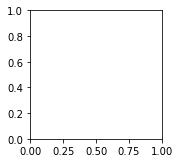

In [8]:
fig3, ax3 = plt.subplots(1,1, sharex=True, sharey=True, figsize=(cm2inch(6, 6)))


Yvv = [new.Q_netA_gpr, new.Q_netA, new.Q_netAF]
Yvv_lbl=[r'$V^{\uparrow}_{IPR}$',r'$V^{\uparrow}_{OGGM}$',r'$V^{\uparrow}_{Farin}$']

ax3.scatter(stakes.Elev_Old+25.,stakes.velocity,color='#1c9099',label='Stakes', alpha=0.6, 
            s=6,facecolor='', zorder=3)
# AX=ax3.twinx()
# for i in range(3):
#     ax3.scatter(new.dem_mean, Yvv[i], edgecolor='k', marker=sym[i+1], alpha=0.6, label=Yvv_lbl[i], s=35, 
#                        color=color[i+1], zorder=2, linewidth=0.25)
meanlineprops = dict(linestyle='--', lw=0.5, color='r');medianprops = dict(linestyle='-', lw=0.5,color='k')
boxprops = dict(linewidth=0.25);
BOXVEL=ax3.boxplot(vfg_all,meanprops=meanlineprops,medianprops=medianprops,boxprops=boxprops,whiskerprops=boxprops, showmeans=True,
                  meanline=True, sym='', positions=gate_elev,widths=30, zorder=1)

# ax3.set_xticks([2000, 2200, 2400, 2600, 2800, ])  #, 2650])
ax3.xaxis.set_major_locator(ticker.MultipleLocator(200))
# ax3.set_xticklabels([2100, 2200,  2300, 2400, 2500, 2600]) 
ax3.set_xticklabels(['',2000, '', 2400, '', 2800, '',3200, ''])
ax3.set(xlim=(1850, 3150))

# ax3.legend(loc='upper right', labelspacing=0.35)
fig3.text(0.005, 0.7, 'Ice velocity (m $a^{-1}$)',rotation=90)
# fig3.text(0.005, 0.65, r'$V^{\uparrow}$' + '(m ice $a^{-1}$)',rotation=90) #transform=ax3.transAxes)
# fig3.text(0.94, 0.7, 'Ice velocity (m $a^{-1}$)',rotation=90)

fig3.subplots_adjust(bottom=0.11, top=0.98, hspace=0.1, left=0.15, right=0.98, wspace=0.05)
fig3.savefig(fl_path + 'products/' + glacier[gl] + '_Velocities_only.pdf', dpi=300)

In [ ]:
stakes['VV_tan']=(stakes.Elev_New-stakes.Elev_Old)/(stakes.time_days/365.) - stakes.velocity.values*np.tan(np.deg2rad(stakes.slope.values))
stakes['VV_D_A']=np.abs(stakes.B_dh) - np.abs(stakes.Elev_New-stakes.Elev_Old)
# stakes.VV_tan[stakes.time_days<200]=np.nan
# stakes['VV_d_stake']=stakes.Alt_D-stakes.B_dh

In [ ]:
fig3, ax3 = plt.subplots(1,1, sharex=True, sharey=True, figsize=(cm2inch(6, 6))) ##mass conservation plot
color = ['k', 'teal', '#74c476', '#238b45']
Yvv = [new.Q_netA_gpr, new.Q_netA, new.Q_netAF]
Yvv_lbl=[r'$V^{\uparrow}_{IPR}$',r'$V^{\uparrow}_{OGGM}$',r'$V^{\uparrow}_{Farin}$']

# ax3.scatter(stakes.Elevation+25.,stakes.VV,color='k',label='Stakes', alpha=0.9, 
#             s=6,facecolor='', zorder=3)

# ax3.scatter(stakes.Elevation+25.,stakes.VV*0.9,color='r',label='Stakes', alpha=0.9, 
#             s=6,facecolor='', zorder=3)
# ax3.scatter(stakes.Elev_Old+25.,stakes.VV_d_stake*0.9,color='r',label='Stakes', alpha=0.9, 
#             s=6,facecolor='', zorder=3)
ax3.scatter(stakes.Elev_Old+25.,stakes.VV_tan*0.9,color='k',label='Stakes', alpha=0.9, 
            s=6,facecolor='', zorder=3)
ax3.scatter(stakes.Elev_Old+25.,stakes.VV_d*0.9,color='#1c9099',label='Stakes VV_d DEM', alpha=0.9, 
            s=6,facecolor='', zorder=3)
ax3.scatter(stakes.Elev_Old+25.,stakes.VV_D_A*0.9,color='r',label='Stakes VV_D_A', alpha=0.9, 
            s=6,facecolor='', zorder=3)

for i in range(3):
    ax3.scatter(new.dem_mean, Yvv[i], edgecolor='k', marker=sym[i+1], alpha=0.6, label=Yvv_lbl[i], s=35, 
                       color=color[i+1], zorder=2, linewidth=0.25)
# meanlineprops = dict(linestyle='--', lw=0.5, color='r');medianprops = dict(linestyle='-', lw=0.5,color='k')
# boxprops = dict(linewidth=0.25);
# BOXVEL=ax3.boxplot(vfg_all,meanprops=meanlineprops,medianprops=medianprops,boxprops=boxprops,whiskerprops=boxprops, showmeans=True,
#                   meanline=True, sym='', positions=gate_elev,widths=30, zorder=1)

# ax3.set_xticks([2000, 2200, 2400, 2600, 2800, ])  #, 2650])
ax3.xaxis.set_major_locator(ticker.MultipleLocator(200))
# ax3.set_xticklabels([2100, 2200,  2300, 2400, 2500, 2600]) 
ax3.set_xticklabels(['',2000, '', 2400, '', 2800, '',3200, ''])
ax3.set(xlim=(1850, 3175));ax3.set(ylim=(-5, 7))

# ax3.legend(loc='upper right', labelspacing=0.35)
# fig3.text(0.005, 0.7, 'Ice velocity (m $a^{-1}$)',rotation=90)
fig3.text(0.005, 0.65, r'$V^{\uparrow}$' + '(m ice $a^{-1}$)',rotation=90) #transform=ax3.transAxes)
# fig3.text(0.94, 0.7, 'Ice velocity (m $a^{-1}$)',rotation=90)

fig3.subplots_adjust(bottom=0.11, top=0.98, hspace=0.1, left=0.2, right=0.98, wspace=0.05)
fig3.savefig(fl_path + 'products/' + glacier[gl] + '_Emergence_Velocities_D_A.png', dpi=300)

In [ ]:
pd.set_option('display.max_columns', None)
stakes

## 3-Panel plot surface velocity

In [ ]:
######## save Conrad data as pickle ##############

# glacier= ['Conrad', 'Kokanee', 'Illecillewaet']
fig_path= '/home/pelto/Desktop/ice_flux/figures/'
import pickle
with open(fig_path + 'conrad_vfg_all.pkl', 'wb') as f:
    pickle.dump(vfg_all, f)
with open(fig_path + 'conrad_gate_elev.pkl', 'wb') as f:
    pickle.dump(gate_elev, f)
new.to_csv(fig_path + 'conrad_new_2018.csv')

# with open(fig_path + glacier[1] +'_vfg_all.pkl', 'rb') as f:
#     vfg_all = pickle.load(f)
# with open(fig_path + glacier[1] + '_gate_elev.pkl', 'rb') as f:
#     gates_elev = pickle.load(f)

In [ ]:
# g=1
# VV=pd.read_csv(fig_path+ glacier[g]+ '_new_2018.csv')
# with open(fig_path + glacier[g] +'_vfg_all.pkl', 'rb') as f:
#     VFG = pickle.load(f)
# with open(fig_path +glacier[g] +'_gate_elev.pkl', 'rb') as f:
#     gates_elev = pickle.load(f)

In [ ]:
###### binned stake observations for each flux bin ##############

with open(fig_path + 'conrad_gate_elev.pkl', 'rb') as f:
    gates_elev = pickle.load(f)

stk_fg=[];
for i in range(len(new.dem_med)): 
    f = new.dem_med[i]
    W=0;bin_size = new.dem_std[i]*2.; COU=1
    while W==0:
        stkfg = [];
        for n in range(len(stakes)):
            if ((f - bin_size) <= stakes.Elev_Old[n]) and (stakes.Elev_Old[n] <=  (f + bin_size)):
                O = stakes.velocity[n]
                stkfg.append(O);

#         if len(OBSFG)<2 and bin_size<150:
#             bin_size=bin_size*(1+(.2*COU))
#             COU=COU+1
        else:
            stk_fg.append(np.array(stkfg));
            W=1

In [ ]:
###### binned stake observations for each flux bin ##############

k=pd.read_csv(fig_path+ 'kokanee_new_2018.csv')
k

Kstk_fg=[];
for i in range(len(k.dem_med)): 
    f = k.dem_med[i]
    W=0;bin_size = k.dem_std[i]*2.; COU=1
    while W==0:
        Kstkfg = [];
        for n in range(len(k_stakes)):
            if ((f - bin_size) <= k_stakes.Elev[n]) and (k_stakes.Elev[n] <=  (f + bin_size)):
                O = k_stakes.Velocity[n]
                Kstkfg.append(O);

#         if len(OBSFG)<2 and bin_size<150:
#             bin_size=bin_size*(1+(.2*COU))
#             COU=COU+1
        else:
            Kstk_fg.append(np.array(Kstkfg));
            W=1

In [ ]:
import seaborn as sns
########### plot for all three glaciers
year =[2016,2017,2018]
fig3, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(cm2inch(8.5, 18))) 
a=ax1,ax2,ax3
widths=25,25,20
for g in range(3):
    fpath=fl_path[:-7]+Glacier[g]+'/'#[g]
    
                
#     for i in range(3):
       # P=[2,4,6,8,10,12,14,16,18]
#         YR = year[i]
        #D=data[data.year==YR]

    
    
    
    
    colors = ['#bdc9e1', '#74a9cf', '#0570b0', '#cb181d', '#88419d', '#8c6bb1'] #, '#8c96c6']
    colors = ['#003f5c','#bc5090','#ffa600']

    Bob = sns.boxplot(x=data.year, y=data.V, hue=data.source, palette=colors, 
                saturation=0.7, linewidth=0.80, fliersize=1, ax=a[g]) 
    
    a[g].text(0.03, 0.92, letter[g], transform=a[g].transAxes)
    if g==1:
        a[g].text(0.75, 0.92, Glacier[g], transform=a[g].transAxes)
    else:
        a[g].text(0.8, 0.92, Glacier[g], transform=a[g].transAxes) 
        
        #hue_order= ['vz', 'vfg'], order=["Zillmer", "Nordic","Illec.", "W. Wash.", "Haig","Conrad", "Kokanee"]
        
        
#         meanlineprops = dict(linestyle='--', lw=0.5, color='r');medianprops = dict(linestyle='-', lw=0.5,color='k')
#         boxprops = dict(linewidth=0.25);
#         BOXVEL=a[g].boxplot(data[data.year==YR].V.values,meanprops=meanlineprops,medianprops=medianprops,boxprops=boxprops, 
#                 whiskerprops=boxprops, showmeans=True, meanline=True, positions=data.year[data.year==YR].values 
#                 ,labels=data[data.year==YR].source.values, sym='',widths=widths[g],capprops=boxprops,zorder=1) #, positions=float(YR)
#         
#     if g==0:
#         GE=[]
#         for i in range(len(gates_elev)):
#             G=gates_elev[i]-30;  GE.append(G)
#         bx=dict(linewidth=0.25);flp=dict(color='#1c9099',s=10,facecolor='')
#         BOXstakes=ax1.boxplot(stk_fg[:-7],meanprops=meanlineprops,medianprops=medianprops,boxprops=bx, 
#             whiskerprops=boxprops, showmeans=True, meanline=True, sym='', positions=GE[:-6],widths=widths[g], 
#             capprops=boxprops,flierprops=flp,zorder=1,patch_artist=True)
       
#         clrs='lightblue'
#         for patch, color in zip(BOXstakes['boxes'], clrs):
#             patch.set_facecolor(clrs)
            
#     if g==2:
#         GE=[]
#         for i in range(len(gates_elev)):
#             G=gates_elev[i]-25;  GE.append(G)
#         kBOXstakes=ax3.boxplot(Kstk_fg[:-2],meanprops=meanlineprops,medianprops=medianprops,boxprops=bx, 
#             whiskerprops=boxprops, showmeans=True, meanline=True, sym='', positions=GE[:-1],widths=widths[g], 
#             capprops=boxprops,flierprops=flp,zorder=1,patch_artist=True)
#         clrs='lightblue'
#         for patch, color in zip(kBOXstakes['boxes'], clrs):
#             patch.set_facecolor(clrs)
        
#     ax1.xaxis.set_major_locator(ticker.MultipleLocator(200))
#     ax1.set_xticklabels(['',2000, '', 2400, '', 2800, '',3200, '']); ax1.set(xlim=(1875, 3125))
#     ax1.text(0.58, 0.9, 'C10', fontsize=8,transform=ax1.transAxes);ax1.set(ylim=(-2, 51))
#     ax2.set_xticks([2100, 2200,  2300, 2400, 2500, 2600])  #, 2650])
#     ax2.set_xticklabels(["", 2200,  "", 2400, "", 2600]) 
#     ax2.set(xlim=(2090, 2675));#ax2.set_yticklabels([""])
#     ax3.set_xticklabels([2300, '', 2500, '', 2700, '']) 
#     ax3.set_xticks([2300, 2400, 2500, 2600, 2700, 2800]);ax3.set_yticks([0, 5, 10, 15]) 
#     ax3.set(xlim=(2290, 2730));#ax3[2,0].set_yticklabels([""])

#     ax3.set_zorder(1)
#     ax3.patch.set_visible(False)
    


# ax3[2,0].legend(loc='upper right', labelspacing=0.35, bbox_to_anchor=(0.99, 0.94))

# ax2.set_ylabel('Ice velocity (m a$^{-1}$)')    #0.005, 0.68, ,rotation=90)
fig3.subplots_adjust(bottom=0.065, top=0.98, hspace=0.12, left=0.12, right=0.99, wspace=0.09)
# fig3.savefig(fig_path + 'All_Velocities_boxplt.pdf', dpi=300)



# Surface velocity vs stakes boxplot

In [ ]:
##only surface velocity
import warnings
warnings.filterwarnings("ignore")
font = {'family' : 'Helvetica', 'weight' : 'normal',  'size'   : 9};plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1.';pylab.rcParams['ytick.major.pad']='1.';pylab.rcParams['ytick.major.size']='3'
Glacier = ['  Conrad', 'Illecillewaet', 'Kokanee'];glacier = ['conrad', 'illecillewaet', 'kokanee']
########### plot for all three glaciers

fig3, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(cm2inch(9, 15))) ##mass conservation plot
a=ax1,ax2,ax3
widths=25,25,20
for g in range(3):
    VV=pd.read_csv(fig_path+ glacier[g]+ '_new_2018.csv')
    with open(fig_path + glacier[g] +'_vfg_all.pkl', 'rb') as f:
        VFG = pickle.load(f)
    with open(fig_path +glacier[g] +'_gate_elev.pkl', 'rb') as f:
        gates_elev = pickle.load(f)
            
    for i in range(3):
        meanlineprops = dict(linestyle='--', lw=0.5, color='r');medianprops = dict(linestyle='-', lw=0.5,color='k')
        boxprops = dict(linewidth=0.25);
        BOXVEL=a[g].boxplot(VFG,meanprops=meanlineprops,medianprops=medianprops,boxprops=boxprops, 
                whiskerprops=boxprops, showmeans=True, meanline=True, sym='', positions=gates_elev,widths=widths[g], 
                capprops=boxprops,zorder=1)
    if g==0:
        GE=[]
        for i in range(len(gates_elev)):
            G=gates_elev[i]-30;  GE.append(G)
        bx=dict(linewidth=0.25);flp=dict(color='#1c9099',s=10,facecolor='')
        BOXstakes=ax1.boxplot(stk_fg[:-7],meanprops=meanlineprops,medianprops=medianprops,boxprops=bx, 
            whiskerprops=boxprops, showmeans=True, meanline=True, sym='', positions=GE[:-6],widths=widths[g], 
            capprops=boxprops,flierprops=flp,zorder=1,patch_artist=True)
       
        clrs='lightblue'
        for patch, color in zip(BOXstakes['boxes'], clrs):
            patch.set_facecolor(clrs)
            
    if g==2:
        GE=[]
        for i in range(len(gates_elev)):
            G=gates_elev[i]-25;  GE.append(G)
        kBOXstakes=ax3.boxplot(Kstk_fg[:-2],meanprops=meanlineprops,medianprops=medianprops,boxprops=bx, 
            whiskerprops=boxprops, showmeans=True, meanline=True, sym='', positions=GE[:-1],widths=widths[g], 
            capprops=boxprops,flierprops=flp,zorder=1,patch_artist=True)
        clrs='lightblue'
        for patch, color in zip(kBOXstakes['boxes'], clrs):
            patch.set_facecolor(clrs)
        
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(200))
    ax1.set_xticklabels(['',2000, '', 2400, '', 2800, '',3200, '']); ax1.set(xlim=(1875, 3125))
    ax1.text(0.58, 0.9, 'C10', fontsize=8,transform=ax1.transAxes);ax1.set(ylim=(-2, 51))
    ax2.set_xticks([2100, 2200,  2300, 2400, 2500, 2600])  #, 2650])
    ax2.set_xticklabels(["", 2200,  "", 2400, "", 2600]) 
    ax2.set(xlim=(2090, 2675));#ax2.set_yticklabels([""])
    ax3.set_xticklabels([2300, '', 2500, '', 2700, '']) 
    ax3.set_xticks([2300, 2400, 2500, 2600, 2700, 2800]);ax3.set_yticks([0, 5, 10, 15]) 
    ax3.set(xlim=(2290, 2730));#ax3[2,0].set_yticklabels([""])

    ax3.set_zorder(1)
    ax3.patch.set_visible(False)
    
    a[g].text(0.03, 0.92, letter[g], transform=a[g].transAxes)
    if g==1:
        a[g].text(0.75, 0.92, Glacier[g], transform=a[g].transAxes)
    else:
        a[g].text(0.8, 0.92, Glacier[g], transform=a[g].transAxes)    

ax1.scatter(stakes.Elev_Old[stakes.velocity>40],stakes.velocity[stakes.velocity>40],color='#1c9099',label='Stakes', alpha=0.9, 
            s=10,facecolor='', zorder=3)
ax3.scatter(k_stakes.Elev,k_stakes.Velocity,color='#1c9099',label='Stakes', alpha=0.95, 
            s=10,facecolor='', zorder=3)
# ax3[2,0].legend(loc='upper right', labelspacing=0.35, bbox_to_anchor=(0.99, 0.94))

ax2.set_ylabel('Ice velocity (m a$^{-1}$)')    #0.005, 0.68, ,rotation=90)
ax3.set_xlabel('Elevation (m a.s.l.)')
fig3.subplots_adjust(bottom=0.065, top=0.98, hspace=0.12, left=0.12, right=0.99, wspace=0.09)
fig3.savefig(fig_path + 'All_Velocities_boxplt.pdf', dpi=300)



## 3-Panel plot emergence velocity

In [ ]:
# np.mean([new.Q_netAF[0], new.Q_netA_gpr[0], new.Q_netA[0]])
# np.mean([new.dh_mean[0], new16.dh_mean[0], new17.dh_mean[0]])

In [ ]:
# print(np.nanmean(stakes[stakes['Name']=='CST0'].B_dh))
# print(np.nanmean(I_stakes[I_stakes[' ID']=='20'].Ba_h))
# print(np.nanmean(I_stakes[I_stakes[' ID']=='20'].VV_d))
# print(np.nanmean(I_stakes[I_stakes[' ID']=='20'].dh_r))
# print(np.nanmean(k_stakes[k_stakes['ID']=='KST55'].B_dh))
# print(np.nanmean(k_stakes[k_stakes['ID']=='KST55'].dh_r))
# print(np.nanmean(k_stakes[k_stakes['ID']=='KST55'].VV))
# # I_stakes[I_stakes[' ID']=='20'].Ba_h
# np.mean([0.782,0.975])
# stakes[stakes.Name=='CST0'].B_dh

In [ ]:
I_stakes_mean = [2.97,1.89,0.76,np.nan,-0.83,-1.57];I_stakes_mean_elev =[2206.26, 2325.64, 2395.14, 2479.68, 2547.14, 2585.20]
k_stakes_mean=[1.37,1.01,0.56];k_stakes_mean_elev=[2289.58, 2422.68,2519.7]
C_stakes_mean=[0.98,2.20,2.13,1.49,1.48,1.01,-1.11];C_stakes_mean_elev=[1998.67, 2079.7 , 2127.6 , 2215.65, 2334.59, 2426.14, 2554.7]

In [ ]:
# pd.set_option('display.max_rows', None)
# stakes

In [ ]:
##only emergence velocity
import pickle
font = {'family' : 'Helvetica', 'weight' : 'normal',  'size'   : 9}
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1.';pylab.rcParams['ytick.major.pad']='1.'
fig_path= '/home/pelto/Desktop/ice_flux/figures/' ;pylab.rcParams['ytick.major.size']='3'
Glacier = ['Conrad', 'Illecillewaet','Kokanee', 'Nordic','Zillmer']
glacier = ['conrad', 'illecillewaet','kokanee', 'nordic', 'zillmer']
########### plot for all three glaciers

fig3, ax3 = plt.subplots(1,5, sharey=True, figsize=(cm2inch(18, 5))) ##mass conservation plot
color = ['k', '#51c2d5','#663f3f','#ec4646']
letter=['A','B','C','D','E']
for g in range(len(glacier)):
#     VV=pd.read_csv(fig_path+ glacier[g]+ '_new_2018.csv')
    fpath=fl_path[:-7]+Glacier[g]+'/'
    with open(fpath + glacier[g] +'_new18.pkl', 'rb') as f:
        VV = pickle.load(f)
#     with open(fig_path + glacier[g] +'_vfg_all.pkl', 'rb') as f:
#         vfg_all = pickle.load(f)
#     with open(fig_path +glacier[g] +'_gate_elev.pkl', 'rb') as f:
#         gates_elev = pickle.load(f)
    

    for i in range(3):
        
        Yvv = [VV.Q_netA_gpr, VV.Q_netA, VV.Q_netAF]
        Yvv_lbl=[r'$V_{z,IPR}$',r'$V_{z,OGGM}$',r'$V_{z,Farin}$']
        print(np.mean([VV.Q_netA_gpr[0], VV.Q_netA[0], VV.Q_netAF[0]]))

        ax3[g].scatter(VV.dem_mean, Yvv[i], edgecolor=color[i+1], marker=sym[i+1], alpha=0.9, label=Yvv_lbl[i],
                       s=40, color=color[i+1], zorder=1+i, linewidth=0.25,facecolor='',lw=mew+.1)
#     ax3[0].set_ylim(-12,8)     
    ax3[1].yaxis.set_major_locator(ticker.MultipleLocator(1));#set_xticks([2100, 2200,  2300, 2400, 2500, 2600])
    if g == 0:
        ax3[0].xaxis.set_major_locator(ticker.MultipleLocator(200));
        ax3[0].set_xticklabels(['',2000, '', 2400, '', 2800, '']); ax3[0].set(xlim=(1850, 3100))#, ylim=(-3.2,3.2))
    elif g==1:
        ax3[1].set_xticks([2100, 2200,  2300, 2400, 2500, 2600])  #, 2650])
        ax3[1].set_xticklabels(["", 2200,  "", 2400, "", 2600]) 
        ax3[1].set(xlim=(2150, 2650))#AX.set_yticklabels([""])
    elif g==2:
        ax3[g].xaxis.set_major_locator(ticker.MultipleLocator(200));
        ax3[2].set_xticklabels([2300, '', 2500, '', 2700, '']) 
        ax3[g].set_xticks([2300, 2400, 2500, 2600, 2700, 2800]) 
    elif g==3:
        ax3[g].xaxis.set_major_locator(ticker.MultipleLocator(200));
        ax3[3].set_xticklabels(['','', '2400', '', 2800]) 
    elif g==4:
        ax3[g].xaxis.set_major_locator(ticker.MultipleLocator(200));
#         ax3[2].set_xticklabels([2300, '', 2500, '', 2700, '']) 
#         ax3[g].set_xticks([2300, 2400, 2500, 2600, 2700, 2800]

    
    ax3[g].set_zorder(1)
    ax3[g].patch.set_visible(False)
    
    ax3[g].text(0.90, 0.03, letter[g], transform=ax3[g].transAxes)
    ax3[g].text(0.97, 0.92, Glacier[g], transform=ax3[g].transAxes, ha='right')
    
    #     if g==0:
#         ax3[g].text(0.75, 0.95, Glacier[g], transform=ax3[g].transAxes)
#     elif g==1:
#         ax3[g].text(0.6, 0.95, Glacier[g], transform=ax3[g].transAxes)
#     else:
#         ax3[g].text(0.7, 0.95, Glacier[g], transform=ax3[g].transAxes)

    ax3[g].axhline(linewidth=1, color='k', ls='--', alpha=0.25, zorder=0)
    
    # ELA 2013--2018
    ELA=[2591,2549,2605,2588,2466]; ELA_std=[58,51,61,37,42]
    ax3[g].errorbar(ELA[g],0.,xerr=ELA_std[g],color='k', alpha=.9, fmt='o',ms=4, zorder=7,lw=mew+.1,label='ELA')
       
###individual stakes
# ax3[0].scatter(stakes.Elev_Old,stakes.VV_tan,color='r',label='StakesTAN', alpha=0.9, 
#             s=8,facecolor='', zorder=6)
# ax3[1].scatter(I_stakes.Elev,I_stakes.VV_d,color='k',label='', alpha=0.4, 
#             s=8,facecolor='', zorder=6)
# ax3[2].scatter(k_stakes.Elev,k_stakes.VV,color='k',label='', alpha=0.4, 
#             s=8,facecolor='', zorder=6)
# ax3[0].scatter(stakes.Elev_Old+25.,stakes.VV,color='r',label='Stakes', alpha=0.9, 
#             s=8,facecolor='', zorder=6)
# ax3[0].scatter(stakes.Elev_Old+25.,stakes.VV_diff,color='k',label='', alpha=0.4, 
#             s=8,facecolor='', zorder=6)

## grouped stakes
ax3[1].scatter(I_stakes_mean_elev,I_stakes_mean,color='k',label='Stakes', alpha=.9, 
            s=40,facecolor='', zorder=6,lw=mew+.1)
ax3[2].scatter(k_stakes_mean_elev,k_stakes_mean,color='k',label='Stakes', alpha=.9, 
            s=40,facecolor='', zorder=6,lw=mew+.1)
ax3[0].scatter(C_stakes_mean_elev,C_stakes_mean,color='k',label='Stakes', alpha=.9, 
            s=40,facecolor='', zorder=6,lw=mew+.1)

ax3[1].legend(loc='lower left', labelspacing=0.2, ncol=1,columnspacing=0.2,handletextpad=0.1,
              borderpad=0.07,borderaxespad=0.15) #, bbox_to_anchor=(0.99, 0.94))

fig3.text(0.005, 0.62, r'$V_{z}$' + ' (m ice $a^{-1}$)',rotation=90) #transform=ax3[g].transAxes)
# fig3.text(0.975, 0.67, 'Ice velocity (m $a^{-1}$)',rotation=90)
ax3[2].set_xlabel('Elevation (m a.s.l.)')#;ax3[0].set_ylabel(r'$V_{z}$' + ' (m ice $a^{-1}$)')
fig3.subplots_adjust(bottom=0.185, top=0.99, hspace=0.05, left=0.065, right=0.99, wspace=0.09)
fig3.savefig(fig_path + 'Emergence_velocities_5.png', dpi=300)

# Conrad Statistics

In [7]:
ELA_sat=[];sELA_sat=[]
for i in range(len(ELA)):
    ELA_sat= ELA_sat+ ([ELA[i]] * 4)
    sELA_sat= sELA_sat+ ([s_ELA[i]] * 4)
ELA_sat,sELA_sat

([2530, 2530, 2530, 2530, 2600, 2600, 2600, 2600, 2645, 2645, 2645, 2645],
 [135, 135, 135, 135, 110, 110, 110, 110, 90, 90, 90, 90])

In [25]:
# MSE_ABL,MSE_ACC, 'MSE_ABL','MSE_ACC',RSR, NSE,
method=[]
for i in range(4):
    method.extend(label)
len(method)
STATS=pd.DataFrame(list(zip(method,SL_L[:,0], SE_L[:,1],SL[:,0], SE[:,1],SL[:,1], SE[:,2], ELA_pw ,ELA_sat,sELA_sat,ME,MAE)),#PBias 
                     columns=['method','ALL','ALLse','ABL', 'ABLse', 'ACC', 'ACCse', 'ELA', 'ELA_sat' ,'sELA_sat','ME','MAE']) #'PBias'
STATS.ALL=STATS.ALL*1000;STATS.ALLse=STATS.ALLse*1000;STATS.ABL=STATS.ABL*1000;STATS.ABLse=STATS.ABLse*1000;
STATS.ACC=STATS.ACC*1000;STATS.ACCse=STATS.ACCse*1000
STATS

# STATS.ACC[STATS.method=='Observed'].min()/STATS.ACC[STATS.method=='Observed'].max()
# STATS.ACC.mean()/STATS.ABLse.mean()

# STATS=pd.read_pickle(FLP+Glacier[1]+ '/' + glacier[1]+ '_NOfirn_PW_stats.pkl')
# STATS

M= ['Observed','FG IPR','FG OGGM','FG Farinotti']
for m in M:
    L= STATS[STATS.method==m].values
    MEAN= np.nanmean(L[:,1:],axis=0)
    MEAN= np.insert(MEAN,0,m)
    STATS= STATS.append(dict(zip(STATS.columns, MEAN)),ignore_index=True)
STATS=STATS.round(2);STATS.ABLse=STATS.ABLse.round(1);STATS.ACCse=STATS.ACCse.round(1);STATS.ALLse=STATS.ALLse.round(1)
STATS.ELA=STATS.ELA.round(0);STATS.ELA=pd.to_numeric(STATS.ELA, downcast='integer')  #.round(0)#STATS.PBias=STATS.PBias.round(1)
STATS.ELA_sat=STATS.ELA_sat.round(0);STATS.ELA_sat=pd.to_numeric(STATS.ELA_sat, downcast='integer') 
STATS.sELA_sat=STATS.sELA_sat.round(0);STATS.sELA_sat=pd.to_numeric(STATS.sELA_sat, downcast='integer') 
if firn == True:
    STATS.to_pickle(fl_path+glacier[gl]+'_stats_firn_LIN_stats.pkl')
else:
    STATS.to_pickle(fl_path+glacier[gl]+'_stats_NOfirn_LIN_stats.pkl')
#     STATS.to_pickle(fl_path+'conrad_stats_ITS_LIVE_NOfirn.pkl')
#     STATS.to_pickle(fl_path+glacier[gl]+'_stats_mosaic_NOfirn.pkl')
STATS

,method,ALL,ALLse,ABL,ABLse,ACC,ACCse,ELA,ELA_sat,sELA_sat,ME,MAE
0,Observed,6.24,0.6,9.59,0.6,2.43,1.3,2520,2530,135,0.00,0.00
1,FG IPR,7.90,1.0,9.94,2.2,5.66,4.3,2563,2530,135,0.14,0.88
2,FG OGGM,7.76,1.1,11.03,2.4,4.04,4.7,2536,2530,135,0.22,0.92
3,FG Farinotti,7.65,0.9,10.48,1.9,4.44,3.8,2539,2530,135,0.10,0.81
4,Observed,6.72,0.8,10.58,0.9,1.00,1.9,2577,2600,110,0.00,0.00
5,FG IPR,6.52,0.7,8.97,1.3,3.05,2.9,2652,2600,110,0.08,0.69
6,FG OGGM,6.32,0.9,9.79,1.5,1.20,3.3,2624,2600,110,0.27,0.73
7,FG Farinotti,6.24,0.7,9.25,1.2,1.79,2.6,2633,2600,110,0.15,0.62
8,Observed,6.81,0.5,9.76,0.7,3.88,1.2,2515,2645,90,0.00,0.00
9,FG IPR,7.12,0.7,10.29,1.3,4.05,2.3,2472,2645,90,-0.38,0.56


In [26]:
S1=STATS.copy()
AB=[];AC=[];AL=[];EL=[];
for i in range(len(S1)):
    AL.append(str(S1.ALL[i])+' $\pm$ '+str(S1.ALLse[i]))
    AB.append(str(S1.ABL[i])+' $\pm$ '+str(S1.ABLse[i]))
    AC.append((str(S1.ACC[i])+' $\pm$ '+str(S1.ACCse[i])))
    EL.append((str(S1.ELA_sat[i])+' $\pm$ '+str(S1.sELA_sat[i])))
S1.ABL=AB;S1.ACC=AC;S1.ALL=AL;S1.ELA_sat=EL
S1.drop(columns=['ABLse','ACCse','ALLse','sELA_sat'], inplace=True)
S1

,method,ALL,ABL,ACC,ELA,ELA_sat,ME,MAE
0,Observed,6.24 $\pm$ 0.6,9.59 $\pm$ 0.6,2.43 $\pm$ 1.3,2520,2530 $\pm$ 135,0.00,0.00
1,FG IPR,7.9 $\pm$ 1.0,9.94 $\pm$ 2.2,5.66 $\pm$ 4.3,2563,2530 $\pm$ 135,0.14,0.88
2,FG OGGM,7.76 $\pm$ 1.1,11.03 $\pm$ 2.4,4.04 $\pm$ 4.7,2536,2530 $\pm$ 135,0.22,0.92
3,FG Farinotti,7.65 $\pm$ 0.9,10.48 $\pm$ 1.9,4.44 $\pm$ 3.8,2539,2530 $\pm$ 135,0.10,0.81
4,Observed,6.72 $\pm$ 0.8,10.58 $\pm$ 0.9,1.0 $\pm$ 1.9,2577,2600 $\pm$ 110,0.00,0.00
5,FG IPR,6.52 $\pm$ 0.7,8.97 $\pm$ 1.3,3.05 $\pm$ 2.9,2652,2600 $\pm$ 110,0.08,0.69
6,FG OGGM,6.32 $\pm$ 0.9,9.79 $\pm$ 1.5,1.2 $\pm$ 3.3,2624,2600 $\pm$ 110,0.27,0.73
7,FG Farinotti,6.24 $\pm$ 0.7,9.25 $\pm$ 1.2,1.79 $\pm$ 2.6,2633,2600 $\pm$ 110,0.15,0.62
8,Observed,6.81 $\pm$ 0.5,9.76 $\pm$ 0.7,3.88 $\pm$ 1.2,2515,2645 $\pm$ 90,0.00,0.00
9,FG IPR,7.12 $\pm$ 0.7,10.29 $\pm$ 1.3,4.05 $\pm$ 2.3,2472,2645 $\pm$ 90,-0.38,0.56


In [27]:
print(S1.to_latex(index=False))

\begin{tabular}{llllrlrr}
\toprule
       method &             ALL &              ABL &             ACC &   ELA &         ELA\_sat &    ME &   MAE \\
\midrule
     Observed &  6.24 \$\textbackslash pm\$ 0.6 &   9.59 \$\textbackslash pm\$ 0.6 &  2.43 \$\textbackslash pm\$ 1.3 &  2520 &  2530 \$\textbackslash pm\$ 135 &  0.00 &  0.00 \\
       FG IPR &   7.9 \$\textbackslash pm\$ 1.0 &   9.94 \$\textbackslash pm\$ 2.2 &  5.66 \$\textbackslash pm\$ 4.3 &  2563 &  2530 \$\textbackslash pm\$ 135 &  0.14 &  0.88 \\
      FG OGGM &  7.76 \$\textbackslash pm\$ 1.1 &  11.03 \$\textbackslash pm\$ 2.4 &  4.04 \$\textbackslash pm\$ 4.7 &  2536 &  2530 \$\textbackslash pm\$ 135 &  0.22 &  0.92 \\
 FG Farinotti &  7.65 \$\textbackslash pm\$ 0.9 &  10.48 \$\textbackslash pm\$ 1.9 &  4.44 \$\textbackslash pm\$ 3.8 &  2539 &  2530 \$\textbackslash pm\$ 135 &  0.10 &  0.81 \\
     Observed &  6.72 \$\textbackslash pm\$ 0.8 &  10.58 \$\textbackslash pm\$ 0.9 &   1.0 \$\textbackslash pm\$ 1.9 &  2577 &  2

# All glacier's stats

In [11]:
Glacier = ['Conrad', 'Illecillewaet','Kokanee', 'Nordic','Zillmer']
glacier = ['conrad', 'illecillewaet','kokanee', 'nordic', 'zillmer']
FLP='/home/pelto/Desktop/ice_flux/' 

if firn ==False:
    K_stats=pd.read_pickle(FLP+ Glacier[2]+ '/' + glacier[2]+ '_stats_NOfirn_LIN_stats.pkl') #NO_firn
    C_stats=pd.read_pickle(FLP+Glacier[0]+ '/' + glacier[0]+ '_stats_NOfirn_LIN_stats.pkl')#'_stats_ITS_LIVE_NOfirn.pkl')#'_firn_LIN_stats.pkl')
    I_stats=pd.read_pickle(FLP+Glacier[1]+ '/' + glacier[1]+ '_stats_NOfirn_LIN_stats.pkl')#'_stats_ITS_LIVE_NOfirn.pkl') #'_LIN_firn_stats.pkl')
    N_stats=pd.read_pickle(FLP+ Glacier[3]+ '/' + glacier[3]+ '_stats_NOfirn_LIN_stats.pkl') #NO_firn
    Z_stats=pd.read_pickle(FLP+Glacier[4]+ '/' + glacier[4]+ '_stats_NOfirn_LIN_stats.pkl')#'_stats_ITS_LIVE_NOfirn.pkl')#'_firn_LIN_stats.pkl')
else:
    K_stats=pd.read_pickle(FLP+ Glacier[2]+ '/' + glacier[2]+ '_stats_firn_LIN_stats.pkl') #NO_firn
    C_stats=pd.read_pickle(FLP+Glacier[0]+ '/' + glacier[0]+ '_stats_firn_LIN_stats.pkl')#'_stats_ITS_LIVE_NOfirn.pkl')#'_firn_LIN_stats.pkl')
    I_stats=pd.read_pickle(FLP+Glacier[1]+ '/' + glacier[1]+ '_stats_firn_LIN_stats.pkl')#'_stats_ITS_LIVE_NOfirn.pkl') #'_LIN_firn_stats.pkl')
    N_stats=pd.read_pickle(FLP+ Glacier[3]+ '/' + glacier[3]+ '_stats_firn_LIN_stats.pkl') #NO_firn
    Z_stats=pd.read_pickle(FLP+Glacier[4]+ '/' + glacier[4]+ '_stats_firn_LIN_stats.pkl')#'_stats_ITS_LIVE_NOfirn.pkl')#'_firn_LIN_stats.pkl')

## ITS LIVE stats
# C_stats=pd.read_pickle(FLP+Glacier[0]+ '/' + glacier[0]+ '_stats_ITS_LIVE_NOfirn.pkl')#
# I_stats=pd.read_pickle(FLP+Glacier[1]+ '/' + glacier[1]+ '_stats_ITS_LIVE_NOfirn.pkl')
# N_stats=pd.read_pickle(FLP+ Glacier[3]+ '/' + glacier[3]+ '_stats_ITS_LIVE_NOfirn.pkl') #NO_firn
# Z_stats=pd.read_pickle(FLP+Glacier[4]+ '/' + glacier[4]+ '_stats_ITS_LIVE_NOfirn.pkl')#

In [150]:
## Mosaic stats
# K_stats=pd.read_pickle(FLP+ Glacier[2]+ '/' + glacier[2]+ '_stats_mosaic_NOfirn.pkl') #NO_firn
# C_stats=pd.read_pickle(FLP+Glacier[0]+ '/' + glacier[0]+ '_stats_mosaic_NOfirn.pkl')#'_stats_ITS_LIVE_NOfirn.pkl')#'_firn_LIN_stats.pkl')
# I_stats=pd.read_pickle(FLP+Glacier[1]+ '/' + glacier[1]+ '_stats_mosaic_NOfirn.pkl')#'_stats_ITS_LIVE_NOfirn.pkl') #'_LIN_firn_stats.pkl')
# N_stats=pd.read_pickle(FLP+ Glacier[3]+ '/' + glacier[3]+ '_stats_mosaic_NOfirn.pkl') #NO_firn
# Z_stats=pd.read_pickle(FLP+Glacier[4]+ '/' + glacier[4]+ '_stats_mosaic_NOfirn.pkl')#'_stats_ITS_LIVE_NOfirn.pkl')#'_firn_LIN_stats.pkl')


In [26]:
########## ALL STATS #####################
tail = True 

I_stats['Glacier']=Glacier[1];C_stats['Glacier']=Glacier[0];K_stats['Glacier']=Glacier[2];
Z_stats['Glacier']=Glacier[3];Z_stats['Glacier']=Glacier[4];

### all av. stats
if tail ==True:
    for i in range(len(frames)):
        frames[i] = frames[i].tail(4)
else:
    frames=[C_stats,I_stats,K_stats,N_stats,Z_stats] ### all stats 
    
ALL_stats=pd.concat(frames, join='inner') # inner keeps order
ALL_stats.ME[ALL_stats.method=='Observed']=np.nan;#ALL_stats.PBias[ALL_stats.method=='Observed']=np.nan
ALL_stats.MAE[ALL_stats.method=='Observed']=np.nan;
print(len(ALL_stats))
ALL_stats.reset_index(inplace=True);ALL_stats.drop(columns=['index'], inplace=True)
# ALL =ALL_stats.copy()
# ALL_stats.drop(columns=['method'], inplace=True)
M= ['Observed','FG IPR','FG OGGM','FG Farinotti']
for m in M:
    L= ALL_stats[ALL_stats.method==m].values
    if m == 'Observed':
        MEAN= np.nanmean(L[:,1:-2],axis=0) # MEAN= np.nanmean(L[:,1:],axis=0)np.nanmean(L[:,:-4],axis=0)
        MEAN=np.append(MEAN,[np.nan,np.nan],axis=0)
        #MEAN=MEAN.tolist()
        #MEAN=np.array(MEAN.extend([1,1,1]))
        
    else:
        MEAN= np.nanmean(L[:,1:],axis=0)  #L[:,:-1]
    MEANI= np.insert(MEAN,0,m)
    ALL_stats= ALL_stats.append(dict(zip(ALL_stats.columns, MEANI)),ignore_index=True)
if tail == True:
    a=[];pdiff=[]
    for i in range(len(frames)+1):
        o=ALL_stats.ALL[i*4]
        for n in range(4):
            b=ALL_stats.ALL[(i*4)+n]
            d = ((o-b)/b)*100
            pdiff.append(d.round(1))    
    ALL_stats['ALL_pdiff']=pdiff;
    ALL_stats.ALL_pdiff[ALL_stats.method=='Observed']=np.nan;   

ALL_stats=ALL_stats.round(2)
ALL_stats

20


,method,ALL,ALLse,ABL,ABLse,ACC,ACCse,ELA,ELA_sat,sELA_sat,ME,MAE,ALL_pdiff
0,Observed,6.59,0.60,9.98,0.0,2.44,0.0,2537.0,2592.0,112.0,NaN,NaN,NaN
1,FG IPR,7.18,0.80,9.73,0.0,4.25,0.0,2562.0,2592.0,112.0,-0.05,0.71,-8.2
2,FG OGGM,6.98,0.90,10.63,0.0,2.64,0.0,2540.0,2592.0,112.0,0.09,0.74,-5.6
3,FG Farinotti,6.89,0.80,10.11,0.0,3.07,0.0,2543.0,2592.0,112.0,-0.03,0.66,-4.4
4,Observed,12.19,1.43,NaN,NaN,NaN,NaN,2517.0,2522.0,72.0,NaN,NaN,NaN
5,FG IPR,13.72,2.30,NaN,NaN,NaN,NaN,2516.0,2522.0,72.0,0.12,0.53,-11.1
6,FG OGGM,13.24,2.38,NaN,NaN,NaN,NaN,2524.0,2522.0,72.0,0.18,0.67,-7.9
7,FG Farinotti,11.76,1.70,NaN,NaN,NaN,NaN,2523.0,2522.0,72.0,0.02,0.46,3.7
8,Observed,7.42,0.70,NaN,NaN,NaN,NaN,2603.0,2562.0,63.0,NaN,NaN,NaN
9,FG IPR,6.53,0.50,NaN,NaN,NaN,NaN,2613.0,2562.0,63.0,-0.01,0.30,13.6


In [29]:
np.nanmean(ALL_stats.ALL_pdiff),np.nanstd(ALL_stats.ALL_pdiff)
np.nanmean(ALL_stats.tail(4).ALL_pdiff),np.nanstd(ALL_stats.tail(4).ALL_pdiff)

(6.6000000000000005, 4.035674251803119)

In [21]:
### for when using all stats not just tails

a=[];pdiff=[];pdACC=[];pdABL=[]
for i in range(21): #len(frames)+1
    o=ALL_stats.ALL[i*4];k=ALL_stats.ABL[i*4];j=ALL_stats.ACC[i*4];
    for n in range(4):
        b=ALL_stats.ALL[(i*4)+n];ab=ALL_stats.ABL[(i*4)+n]; ac=ALL_stats.ACC[(i*4)+n];
        d = ((o-b)/b)*100;dd = ((k-ab)/ab)*100;ddd = ((j-ac)/ac)*100;
        pdiff.append(np.abs(d.round(1)));pdACC.append(ddd.round(1));pdABL.append(dd.round(1))

ALL_stats['ALL_pdiff']=pdiff;
ALL_stats.ALL_pdiff[ALL_stats.method=='Observed']=np.nan;
ALL_stats

np.nanmean(ALL_stats.ALL_pdiff[:3]);

print('mean pdiff', np.nanmean((ALL_stats.ALL_pdiff[-3:])),np.nanmean(pdABL[5:]),np.nanmean(pdACC[5:]))
print('std pdiff', np.nanstd((ALL_stats.ALL_pdiff[-3:])),np.nanstd(pdABL[5:]),np.nanstd(pdACC[5:]))

mean pdiff 6.566666666666666 3.1129032258064515 39.98709677419355
std pdiff 4.02685430026411 12.776534487362516 339.3415319665097


In [30]:
ALL = ALL_stats[:-4][ALL_stats.method!='Observed']
len(ALL)

np.mean([56,56,53])

# np.median(ALL.ELA_sat-ALL.ELA),np.std(ALL.ELA_sat-ALL.ELA)
ALL['eld']=ALL.ELA_sat-ALL.ELA
a=np.abs(ALL.eld)
print(len(a[a>100]) /len(ALL),np.mean(ALL.eld),np.std(ALL.eld))
np.mean(np.abs(ALL.eld))

15

In [81]:
######### Mosaic STATS ###############
I_stats['Glacier']=Glacier[1];C_stats['Glacier']=Glacier[0];K_stats['Glacier']=Glacier[2];
Z_stats['Glacier']=Glacier[3];Z_stats['Glacier']=Glacier[4];

frames=[C_stats,I_stats,K_stats,N_stats,Z_stats]
for i in range(len(frames)):
    frames[i] = frames[i].tail(4)
# frames=[C_stats,I_stats,K_stats,N_stats,Z_stats]
ALL_statsM=pd.concat(frames, join='inner') # inner keeps order
ALL_statsM.ME[ALL_statsM.method=='Observed']=np.nan;#ALL_statsM.PBias[ALL_statsM.method=='Observed']=np.nan
ALL_statsM.MAE[ALL_statsM.method=='Observed']=np.nan;
print(len(ALL_statsM))
ALL_statsM.reset_index(inplace=True);ALL_statsM.drop(columns=['index'], inplace=True)
ALL_statsM



# ALL_statsM.drop(columns=['method'], inplace=True)
M= ['Observed','FG IPR','FG OGGM','FG Farinotti']
for m in M:
    L= ALL_statsM[ALL_statsM.method==m].values
    if m == 'Observed':
        MEAN= np.nanmean(L[:,1:-2],axis=0) # MEAN= np.nanmean(L[:,1:],axis=0)np.nanmean(L[:,:-4],axis=0)
        MEAN=np.append(MEAN,[np.nan,np.nan],axis=0)
        #MEAN=MEAN.tolist()
        #MEAN=np.array(MEAN.extend([1,1,1]))
        
    else:
        MEAN= np.nanmean(L[:,1:],axis=0)  #L[:,:-1]
    MEANI= np.insert(MEAN,0,m)
    ALL_statsM= ALL_statsM.append(dict(zip(ALL_statsM.columns, MEANI)),ignore_index=True)

a=[];pdiff=[]
for i in range(len(frames)+1):
    o=ALL_statsM.ALL[i*4]
    for n in range(4):
        b=ALL_statsM.ALL[(i*4)+n]
        d = ((o-b)/b)*100
        pdiff.append(d.round(1))    
ALL_statsM['ALL_pdiff']=pdiff;
ALL_statsM.ALL_pdiff[ALL_statsM.method=='Observed']=np.nan;    
    
ALL_statsM=ALL_statsM.round(2)
ALL_statsM.tail(4)

20


,method,ALL,ALLse,ABL,ABLse,ACC,ACCse,ELA,ME,MAE,ALL_pdiff
20,Observed,7.81,0.88,11.36,1.90,2.16,2.95,2538.0,NaN,NaN,NaN
21,FG IPR,7.92,1.24,11.22,2.75,4.30,4.50,2554.8,0.05,0.58,-1.4
22,FG OGGM,7.50,1.14,22.49,7.00,2.48,8.10,2564.0,0.10,0.60,4.1
23,FG Farinotti,7.19,1.06,13.22,2.50,2.48,3.50,2561.4,0.03,0.53,8.7


In [103]:
np.nanmean(ALL_stats.tail(4).ALL_pdiff),np.nanmean(ALL_statsM.tail(4).ALL_pdiff)
np.nanmedian(ALL_stats.ALL_pdiff[:-4]),np.nanmedian(ALL_statsM.ALL_pdiff[:-4])

d=(ALL_stats.ALL-ALL_statsM.ALL)/ALL_stats.ALL
d[d==0.00]=np.nan
np.nanmean(d),np.nanstd(d)

(3.7, -3.9)

In [80]:
ALL_stats=pd.read_pickle('/home/pelto/Desktop/ice_flux/figures/ALL_stats_NOfirn_LIN_stats.pkl')
a=[];pdiff=[]
for i in range(len(frames)+1):
    o=ALL_stats.ALL[i*4]
    for n in range(4):
        b=ALL_stats.ALL[(i*4)+n]
        d = ((o-b)/b)*100
        pdiff.append(d.round(1))    
ALL_stats['ALL_pdiff']=pdiff;
ALL_stats.ALL_pdiff[ALL_stats.method=='Observed']=np.nan;  

ALL_stats.tail(4)

,method,ALL,ALLse,ABL,ABLse,ACC,ACCse,ELA,ME,MAE,ALL_pdiff
20,Observed,7.81,0.88,11.36,1.90,2.16,2.95,2538.0,NaN,NaN,NaN
21,FG IPR,7.68,1.26,11.13,2.80,4.60,4.40,2556.6,0.03,0.56,1.7
22,FG OGGM,7.21,1.12,14.28,4.05,3.00,5.70,2563.0,0.07,0.57,8.3
23,FG Farinotti,6.98,1.10,13.33,2.70,2.68,3.90,2561.6,0.02,0.53,11.9


In [ ]:
######### FIRN STATS ###############
I_stats['Glacier']=Glacier[1];C_stats['Glacier']=Glacier[0];K_stats['Glacier']=Glacier[2];
Z_stats['Glacier']=Glacier[3];Z_stats['Glacier']=Glacier[4];

frames=[C_stats,I_stats,K_stats,N_stats,Z_stats]
for i in range(len(frames)):
    frames[i] = frames[i].tail(4)
# frames=[C_stats,I_stats,K_stats,N_stats,Z_stats]
ALL_statsF=pd.concat(frames, join='inner') # inner keeps order
ALL_statsF.ME[ALL_statsF.method=='Observed']=np.nan;#ALL_statsF.PBias[ALL_statsF.method=='Observed']=np.nan
ALL_statsF.MAE[ALL_statsF.method=='Observed']=np.nan;
print(len(ALL_statsF))
ALL_statsF.reset_index(inplace=True);ALL_statsF.drop(columns=['index'], inplace=True)
ALL_statsF

# ALL_statsF.drop(columns=['method'], inplace=True)
M= ['Observed','FG IPR','FG OGGM','FG Farinotti']
for m in M:
    L= ALL_statsF[ALL_statsF.method==m].values
    if m == 'Observed':
        MEAN= np.nanmean(L[:,1:-2],axis=0) # MEAN= np.nanmean(L[:,1:],axis=0)np.nanmean(L[:,:-4],axis=0)
        MEAN=np.append(MEAN,[np.nan,np.nan],axis=0)
        #MEAN=MEAN.tolist()
        #MEAN=np.array(MEAN.extend([1,1,1]))
        
    else:
        MEAN= np.nanmean(L[:,1:],axis=0)  #L[:,:-1]
    MEANI= np.insert(MEAN,0,m)
    ALL_statsF= ALL_statsF.append(dict(zip(ALL_statsF.columns, MEANI)),ignore_index=True)
ALL_statsF=ALL_statsF.round(2)
ALL_statsF.tail(4)

In [4]:
########## ITS LIVE STATS  ###########
I_stats['Glacier']=Glacier[1];C_stats['Glacier']=Glacier[0]
Z_stats['Glacier']=Glacier[3];Z_stats['Glacier']=Glacier[4];

frames=[C_stats,I_stats,N_stats,Z_stats]
for i in range(len(frames)):
    frames[i] = frames[i].tail(4)
# frames=[C_stats,I_stats,K_stats,N_stats,Z_stats]
ALL_ITS=pd.concat(frames, join='inner') # inner keeps order
ALL_ITS.ME[ALL_ITS.method=='Observed']=np.nan;#ALL_ITS.PBias[ALL_ITS.method=='Observed']=np.nan
ALL_ITS.MAE[ALL_ITS.method=='Observed']=np.nan;
# print(len(ALL_ITS))
ALL_ITS.reset_index(inplace=True);ALL_ITS.drop(columns=['index'], inplace=True)
ALL_ITS

# ALL_ITS.drop(columns=['method'], inplace=True)
M= ['Observed','FG IPR','FG OGGM','FG Farinotti']
for m in M:
    L= ALL_ITS[ALL_ITS.method==m].values
    if m == 'Observed':
        MEAN= np.nanmean(L[:,1:-2],axis=0) # MEAN= np.nanmean(L[:,1:],axis=0)np.nanmean(L[:,:-4],axis=0)
        MEAN=np.append(MEAN,[np.nan,np.nan],axis=0)
        #MEAN=MEAN.tolist()
        #MEAN=np.array(MEAN.extend([1,1,1]))
        
    else:
        MEAN= np.nanmean(L[:,1:],axis=0)  #L[:,:-1]
    MEANI= np.insert(MEAN,0,m)
    ALL_ITS= ALL_ITS.append(dict(zip(ALL_ITS.columns, MEANI)),ignore_index=True)

a=[];pdiff=[]
for i in range(len(frames)+1):
    o=ALL_ITS.ALL[i*4]
    for n in range(4):
        b=ALL_ITS.ALL[(i*4)+n]
        d = ((o-b)/b)*100
        pdiff.append(d.round(1))    
ALL_ITS['ALL_pdiff']=pdiff;ALL_ITS.ALL_pdiff[ALL_ITS.method=='Observed']=np.nan;
    
ALL_ITS=ALL_ITS.round(2)
ALL_ITS

,method,ALL,ALLse,ABL,ABLse,ACC,ACCse,ELA,ME,MAE,ALL_pdiff
0,Observed,6.59,0.60,10.06,0.70,1.95,1.50,2536.00,NaN,NaN,NaN
1,FG IPR,5.73,0.80,5.92,2.20,4.32,4.20,2703.00,-0.44,1.03,15.0
2,FG OGGM,5.45,0.90,7.08,1.60,-4.49,8.50,2604.00,-0.26,1.08,20.9
3,FG Farinotti,5.44,0.70,6.89,1.20,-5.30,6.90,2604.00,-0.35,0.99,21.1
4,Observed,12.19,1.40,NaN,NaN,NaN,NaN,2517.00,NaN,NaN,NaN
5,FG IPR,9.24,2.20,NaN,NaN,NaN,NaN,2555.00,0.07,0.87,31.9
6,FG OGGM,9.77,3.20,NaN,NaN,NaN,NaN,2553.00,0.13,0.96,24.8
7,FG Farinotti,8.71,2.00,NaN,NaN,NaN,NaN,2552.00,-0.03,0.75,40.0
8,Observed,4.92,1.20,12.67,3.10,2.37,4.40,2582.00,NaN,NaN,NaN
9,FG IPR,3.50,0.50,4.94,1.00,2.58,1.80,2645.00,-0.07,0.53,40.6


In [ ]:
ALL_ITS.tail(4).MAE.mean()
1-(ALL_stats.tail(3).ALL.mean()/ALL_ITS.tail(3).ALL.mean())

In [7]:
ALL_stats=pd.read_pickle('/home/pelto/Desktop/ice_flux/figures/ALL_stats_firn_LIN_stats.pkl')

ALL_statsF.ME.mean(),ALL_stats.ME.std()

ALL_statsF.tail(4)

1-(ALL_stats.tail(3).ALL.mean()/ALL_statsF.tail(3).ALL.mean())

print(np.nanmean(ALL_stats.ME),np.nanstd(ALL_stats.ME))
print(np.nanmean(ALL_stats.MAE),np.nanstd(ALL_stats.MAE))

In [ ]:
I_stats['Glacier']=Glacier[1];C_stats['Glacier']=Glacier[0];K_stats['Glacier']=Glacier[2];
Z_stats['Glacier']=Glacier[3];Z_stats['Glacier']=Glacier[4];

frames=[C_stats,I_stats,K_stats,N_stats,Z_stats]
for i in range(len(frames)):
    frames[i] = frames[i].tail(4)
# frames=[C_stats,I_stats,K_stats,N_stats,Z_stats]
ALL_stats=pd.concat(frames, join='inner') # inner keeps order
ALL_stats.ME[ALL_stats.method=='Observed']=np.nan;#ALL_stats.PBias[ALL_stats.method=='Observed']=np.nan
ALL_stats.MAE[ALL_stats.method=='Observed']=np.nan;
print(len(ALL_stats))
ALL_stats.reset_index(inplace=True);ALL_stats.drop(columns=['index'], inplace=True)

# ALL_stats.drop(columns=['method'], inplace=True)
M= ['Observed','FG IPR','FG OGGM','FG Farinotti']
for m in M:
    L= ALL_stats[ALL_stats.method==m].values
    if m == 'Observed':
        MEAN= np.nanmean(L[:,1:-2],axis=0) # MEAN= np.nanmean(L[:,1:],axis=0)np.nanmean(L[:,:-4],axis=0)
        MEAN=np.append(MEAN,[np.nan,np.nan],axis=0)
        #MEAN=MEAN.tolist()
        #MEAN=np.array(MEAN.extend([1,1,1]))
        
    else:
        MEAN= np.nanmean(L[:,1:],axis=0)  #L[:,:-1]
    MEANI= np.insert(MEAN,0,m)
    ALL_stats= ALL_stats.append(dict(zip(ALL_stats.columns, MEANI)),ignore_index=True)
ALL_stats=ALL_stats.round(2)
ALL_stats

In [ ]:
S1=ALL_stats.copy()
AB=[];AC=[];AL=[]
for i in range(len(S1)):
    AL.append(str(S1.ALL[i])+' $\pm$ '+str(S1.ALLse[i]))
    AB.append(str(S1.ABL[i])+' $\pm$ '+str(S1.ABLse[i]))
    AC.append((str(S1.ACC[i])+' $\pm$ '+str(S1.ACCse[i])))
S1.ABL=AB;S1.ACC=AC;S1.ALL=AL
S1.drop(columns=['ABLse','ACCse','ALLse'], inplace=True)
S1

In [ ]:
ALL_statsF.to_pickle('/home/pelto/Desktop/ice_flux/figures/ALL_stats_firn_LIN_stats.pkl')
ALL_stats.to_pickle('/home/pelto/Desktop/ice_flux/figures/ALL_stats_NOfirn_LIN_stats.pkl')

In [11]:
a=[];pdiff=[]
for i in range(len(frames)+1):
    o=ALL_stats.ALL[i*4]
    for n in range(4):
        b=ALL_stats.ALL[(i*4)+n]
        d = ((o-b)/b)*100
        pdiff.append(d.round(1))
    

In [ ]:
# print(np.nanmean(pd.to_numeric(ALL_stats.PBias[ALL_stats.method!='Observed'].values)),np.nanstd(pd.to_numeric(ALL_stats.PBias[ALL_stats.method!='Observed'].values)))
print(np.nanmean(pd.to_numeric(ALL_stats.ME[ALL_stats.method!='Observed'].values)),np.nanstd(pd.to_numeric(ALL_stats.ME[ALL_stats.method!='Observed'].values)))
print(np.nanmean(pd.to_numeric(ALL_stats.MAE[ALL_stats.method!='Observed'].values)),np.nanstd(pd.to_numeric(ALL_stats.MAE[ALL_stats.method!='Observed'].values)))

In [ ]:
S1=ALL_stats.copy()
AB=[];AC=[];AL=[]
for i in range(len(S1)):
    AL.append(str(S1.ALL[i])+' $\pm$ '+str(S1.ALLse[i]))
    AB.append(str(S1.ABL[i])+' $\pm$ '+str(S1.ABLse[i]))
    AC.append((str(S1.ACC[i])+' $\pm$ '+str(S1.ACCse[i])))
S1.ABL=AB;S1.ACC=AC;S1.ALL=AL
S1.drop(columns=['ABLse','ACCse','ALLse'], inplace=True)
S1

In [ ]:
print(S1.to_latex(index=False))

In [ ]:
with open('/home/pelto/Desktop/ice_flux/' + Glacier[1] +'/ALL_list.pkl', 'rb') as f:
    illec_all = pickle.load(f)
with open('/home/pelto/Desktop/ice_flux/' + Glacier[2] +'/ALL_list.pkl', 'rb') as f:
    kok_all = pickle.load(f)

NameError: name 'gpr_all' is not defined

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


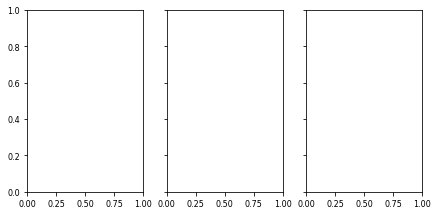

In [9]:
#########  ALL YEARS ALL GLACIERS LIN ####
Glacier = ['Conrad',  'Illecillewaet','Kokanee',]
with open('/home/pelto/Desktop/ice_flux/' + Glacier[1] +'/ALL_list.pkl', 'rb') as f:
    illec_all = pickle.load(f)
with open('/home/pelto/Desktop/ice_flux/' + Glacier[2] +'/ALL_list.pkl', 'rb') as f:
    kok_all = pickle.load(f)

font = {'family' : 'Helvetica', 'weight' : 'normal',  'size'   : 8}
plt.rc('font', **font)
SEa=[];SLa=[]
obs = pd.read_csv(fl_path+ 'Conrad_bdot.csv') 
obs.dropna(subset=['Ba'],inplace=True)
# obs=obs[obs.Year==2016 and obs.Year==2017 and obs.Year==2018]

############## linear function ########################################         
fig3, ax3 = plt.subplots(1,3, sharex=False, sharey=True, figsize=(cm2inch(18, 8.5)))#   figsize=(8,8))#(3.5,3.5)) 

# y_bin=[obs_all,gpr_ALL,opt_all,farin_all]; x_bin=[z_range_all,zr_gpr,z_range_all,z_range_all]
  
label=['Observed', 'FG IPR', 'FG OGGM', 'FG Farinotti']
for r in range(3):
    for i in range(4):      
        if r==0:
            y_bin=[obs.Ba[(obs.Year>2015) & (obs.Year < 2019)],gpr_all,opt_all,farin_all]; x_bin=[obs.Elev[(obs.Year>2015) & (obs.Year < 2019)],elev_gpr_all,elev_all,elev_all];
            x0=2525; breakpoints = [1850.,3300.];xd = np.arange(1950., 3150., 10.);x_hat = np.linspace(1900, 3180, 10)
        elif r==1:
            x_bin=[illec_all[i+4],illec_all[i+4],illec_all[i+4],illec_all[i+4]];
            y_bin=[illec_all[i],illec_all[i],illec_all[i],illec_all[i]];
            x0=2500;  xd = np.linspace(2040, 2660, 10)
            breakpoints = [2040.,2680.];x_hat = np.arange(2040.,2660.,10.)
        else:
            x_bin=[kok_all[i+4],kok_all[i+4],kok_all[i+4],kok_all[i+4]];
            y_bin=[kok_all[i],kok_all[i],kok_all[i],kok_all[i]];xd = np.arange(2280., 2800., 10.)
            x0=2560; breakpoints = [2200.,2900.]; x_hat= np.arange(2280., 2800., 10.)
                        
        def piecewise_linear(x, x0, y0, k1, k2):
            return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0]) 
        
        Y=np.array(y_bin[i]);X=np.array(x_bin[i])
        model = pwlf.PiecewiseLinFit(X, Y)
        model.fit_with_breaks(breakpoints)
        y_hat = model.predict(x_hat)
        ax3[r].plot(x_hat, y_hat, lw=1., alpha=1, color=color[i],zorder=1)
        SLa.append(model.slopes); SEa.append(model.standard_errors())

        x1=np.array(x_bin[i]); y1=np.array(y_bin[i])
        p , e = curve_fit(piecewise_linear, x1, y1 )

        # mean square error of the lines
        MSE_results=[]
        for Line in range(2):
            Pred=[];Act=[]
            if Line ==0:
                INDEX= np.where(x1<x0)[0]
                for ix in INDEX:
                    Pred.append( p[2]*x1[ix]+(p[1]-p[2]*x0))
                    Act.append(y1[ix])

                MSE_results.append(MSE(Act,Pred))
            if Line==1:
                INDEX= np.where(x1>=x0)[0]
                for ix in INDEX:
                    Pred.append( p[3]*x1[ix]+(p[1]-p[3]*x0))
                    Act.append(y1[ix])

                MSE_results.append(MSE(Act,Pred))
        ax3[r].scatter(x_bin[i], y_bin[i], color=color[i], s=10, marker=sym[i], facecolors='none', lw=0.5, label=label[i],
                   zorder=2,alpha=0.7)
    ax3[0].xaxis.set_major_locator(ticker.MultipleLocator(400));ax3[1].xaxis.set_major_locator(ticker.MultipleLocator(200));ax3[2].xaxis.set_major_locator(ticker.MultipleLocator(200))
    ax3[r].text(0.92, 0.03, letter[r], transform=ax3[r].transAxes)
    ax3[2].legend(loc='bottom right', bbox_to_anchor=(0.98, 0.34), labelspacing=0.2, handletextpad=0.1)
    ax3[r].axhline(linewidth=1, color='k', ls='--', alpha=0.25, zorder=0)
    ax3[r].text(0.05, 0.95, Glacier[r], transform=ax3[r].transAxes)
    ax3[0].set(ylim=(-7.5,3.5),ylabel='Mass balance (m w.e.)')
    ax3[1].set(xlabel='Elevation (m a.s.l.)')
fig3.subplots_adjust(bottom=0.15, top=0.98, hspace=0.1, left=0.06, right=0.985, wspace=0.05)
fig3.savefig(fl_path + 'products/' + 'All_glaciers_all_years_combined_LIN.pdf', dpi=300)

In [ ]:
np.nanmean(vz)

In [ ]:
########  ALL YEARS CONRAD ONLY  ####

font = {'family' : 'Helvetica', 'weight' : 'normal',  'size'   : 8}
plt.rc('font', **font)

obs = pd.read_csv(fl_path+ 'Conrad_bdot.csv') 
obs.dropna(subset=['Ba'],inplace=True)
# obs=obs[obs.Year==2016 and obs.Year==2017 and obs.Year==2018]

############## piecewise function ########################################         
fig3, ax3 = plt.subplots(1, sharex=True, sharey=True, figsize=(cm2inch(8.5, 8.5)))#   figsize=(8,8))#(3.5,3.5)) 

# y_bin=[obs_all,gpr_ALL,opt_all,farin_all]; x_bin=[z_range_all,zr_gpr,z_range_all,z_range_all]
def piecewise_linear(x, x0, y0, k1, k2):
    x0=2525.
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])   
label=['Observed', 'FG IPR', 'FG OGGM', 'FG Farinotti'];SEa=[];SLa=[]
y_bin=[obs.Ba,gpr_all,opt_all,farin_all]; x_bin=[obs.Elev,elev_gpr_all,elev_all,elev_all]

for i in range(4):      



    ##pwlf
    Y=np.array(y_bin[i])
    X=np.array(x_bin[i])
    model = pwlf.PiecewiseLinFit(X, Y)
    breakpoints = [1850.,x0,3300.]
    model.fit_with_breaks(breakpoints)
    x_hat = np.linspace(1900, 3270, 10)
    y_hat = model.predict(x_hat)
    plt.plot(x_hat, y_hat, lw=1., alpha=1, color=color[i],zorder=1)
    SLa.append(model.slopes)
    SEa.append(model.standard_errors())
    x1=np.array(x_bin[i]); y1=np.array(y_bin[i])
    p , e = curve_fit(piecewise_linear, x1, y1 )
    xd = np.arange(1950., 3150., 10.)
#     ax3.plot(xd, piecewise_linear(xd, *p), color=color[i], label=label[i], lw=1.0)
    # mean square error of the lines
    x0=2525.

#     MSE_results=[]
    for Line in range(2):
        Pred=[];Act=[]
        if Line ==0:
            INDEX= np.where(x1<x0)[0]
            for ix in INDEX:
                Pred.append( p[2]*x1[ix]+(p[1]-p[2]*x0))
                Act.append(y1[ix])

#             MSE_results.append(MSE(Act,Pred))
        if Line==1:
            INDEX= np.where(x1>=x0)[0]
            for ix in INDEX:
                Pred.append( p[3]*x1[ix]+(p[1]-p[3]*x0))
                Act.append(y1[ix])

#             MSE_results.append(MSE(Act,Pred))
    ax3.scatter(x_bin[i], y_bin[i], color=color[i], s=10, marker=sym[i], facecolors='none', lw=0.5, label=label[i],
               zorder=2,alpha=0.7)
#     meanlineprops = dict(linestyle='--', linewidth=1., color=color[i])
#     medianprops = dict(linestyle='-', linewidth=1, color=color[i])
#     if i == 1:
#         BOX2=ax3.boxplot(y_bin[i],meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,sym='',
#                     positions=[1950, 2050, 2150, 2250, 2350, 2450, 2550, 2650, 2750, 2850, 2950, 3050],widths=75)
#     else:
#         BOX2=ax3.boxplot(y_bin[i],meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,sym='',
#                     positions=[1950, 2050, 2150, 2250, 2350, 2450, 2550, 2650, 2750, 2850, 2950, 3050,3150,3250],widths=75)

#     ax3.text(0.2, ytxt[i], txt[i]+ ' L1: '+ str(np.round(p[2]*1000,2)) +' L2: ' + 
#                     str(np.round(p[3]*1000,2)) + ' AABR: ' + str(np.round(p[2]/p[3],2)),
#                      transform=ax3.transAxes)  
#     ax3.text(0.55, ytxt[i], txt[i] + ' L1: '+ str(round(SL[0]*1000,2))+u" \u00B1 "+ str(round(SE[1]*1000*1.96,2)) +' L2: ' + 
#                    str(round(SL[1]*1000,2))+u" \u00B1 "+ str(round(SE[2]*1000*1.96,2)) ,transform=ax3.transAxes) #+ ' AABR: ' + str(np.round(p[2]/p[3],2)),

ax3.legend(loc='best')
ax3.axhline(linewidth=1, color='k', ls='--', alpha=0.25, zorder=0)
ax3.set(ylim=(-8.,3.1),xlim=(1870,3300),ylabel='Mass balance (m w.e.)',xlabel='Elevation (m a.s.l.)')
#         print(MSE_results)
fig3.savefig(fl_path + 'products/' + glacier[gl]+'_' + balance +'_all_years_combined.pdf', dpi=300)

In [ ]:
Yvv_lbl=['$V^{\uparrow}_{IPR}$','$V^{\uparrow}_{OGGM}$','$V^{\uparrow}_{Farin}$']

In [ ]:
sVSTAKE=1.10; sVOFFice=1.8; sVRAND=3.0
sVsys=np.sqrt((sVSTAKE**2)+(sVOFFice**2))
sVZ=np.sqrt((sVsys**2)+(sVRAND**2))
sVZ

In [ ]:
# fig4, ax4 = plt.subplots(1, sharex=True, sharey=True, figsize=(8,8))#(3.5,3.5)) 
import seaborn as sns
scat_fmt={'marker':'^','linewidths':1,'edgecolor':'k'}


sns.regplot( x="dem_mean", y="b_fg_we", data=new16, fit_reg=False, marker='o',scatter_kws=scat_fmt)

sns.regplot(x="dem_mean", y="dh_mean", data=new16, fit_reg=False, marker='_',scatter_kws=scat_fmt)
sns.regplot(x="dem_mean", y="BMC", data=new16, label=r'$V^{\uparrow}_{IPR}$',fit_reg=False, marker='x',scatter_kws=scat_fmt)

sns.regplot( x="dem_mean", y="Q_netA", data=new16, fit_reg=False, marker='^',scatter_kws=scat_fmt)
sns.regplot( x="dem_mean", y="Q_netAF", data=new16, fit_reg=False, marker='^',scatter_kws=scat_fmt)
sns.regplot( x="dem_mean", y="Q_netA_gpr", data=new16, fit_reg=False,marker='^',scatter_kws=scat_fmt)
sns.regplot( x="dem_mean", y="Q_netA", data=new17, fit_reg=False, marker='^',scatter_kws=scat_fmt)
sns.regplot( x="dem_mean", y="Q_netAF", data=new17, fit_reg=False, marker='^',scatter_kws=scat_fmt)
sns.regplot( x="dem_mean", y="Q_netA_gpr", data=new17, fit_reg=False,marker='^',scatter_kws=scat_fmt)
sns.regplot( x="dem_mean", y="Q_netA", data=new, fit_reg=False, marker='^',scatter_kws=scat_fmt)
sns.regplot( x="dem_mean", y="Q_netAF", data=new, fit_reg=False, marker='^',scatter_kws=scat_fmt)
sns.regplot( x="dem_mean", y="Q_netA_gpr", data=new, fit_reg=False,marker='^',scatter_kws=scat_fmt)
# plt.scatter(D.velocity, D.vz, s=30, edgecolor='#3182bd', facecolor='#a6bddb', linewidth=1.4, label=D.Year)#, zorder=3)
plt.plot(np.arange(0, 55), np.arange(0, 55), 'k--', linewidth=0.75, zorder=1)
plt.xlabel('Elevation m a.s.l.)')
plt.ylabel('Height change (m ice $a^{-1}$)')
plt.xlim(1800,3200);plt.ylim(-5,5)
plt.axhline(linewidth=1, color='k', ls='--', alpha=a+.2, zorder=0)
plt.legend(loc=2)
plt.grid(linestyle=':', linewidth=0.4, color='gray', alpha=0.5, zorder=0)
plt.tight_layout(pad=0.2)

plt.savefig(fl_path+ 'products/Conrad_emergence_vel.png',dpi=300)
plt.show()


In [ ]:
path

In [ ]:
# fig4, ax4 = plt.subplots(1, sharex=True, sharey=True, figsize=(8,4))#(3.5,3.5)) 
# import seaborn as sns
# scat_fmt={'marker':'^','linewidths':1,'edgecolor':'k'}

# V=[new16.vel_fg[1:],new17.vel_fg[1:],new.vel_fg[1:]]
# for i in range(3):
#     ax4.plot(new.dem_mean[1:],V[i])
# # plt.scatter(D.velocity, D.vz, s=30, edgecolor='#3182bd', facecolor='#a6bddb', linewidth=1.4, label=D.Year)#, zorder=3)
# # plt.plot(np.arange(0, 55), np.arange(0, 55), 'k--', linewidth=0.75, zorder=1)
# plt.xlabel('Elevation m a.s.l.)')
# plt.ylabel('Height change (m ice $a^{-1}$)')
# plt.xlim(1800,3200);#plt.ylim(-5,5)
# # plt.axhline(linewidth=1, color='k', ls='--', alpha=a+.2, zorder=0)
# plt.legend(loc=2)
# plt.grid(linestyle=':', linewidth=0.4, color='gray', alpha=0.5, zorder=0)
# plt.tight_layout(pad=0.2)

# # plt.savefig(fl_path+ 'products/Conrad_emergence_vel.png',dpi=300)
# plt.show()


In [ ]:
print(round(np.mean(NSE),2), np.std(NSE))
print(np.mean(PBias), np.std(PBias))
print(np.mean(RSR), np.mean(RSR))
print(np.mean(OBF), np.mean(GPRq), np.mean(OPTq), np.mean(FARq))

In [ ]:
g=0,3,6
o=1,4,7
f=2,5,8
GPR_dat=[]; OPT_dat=[];FAR_dat=[]
for n in range(3):
    GPR_dat.append([NSE[g[n]],PBias[g[n]],RSR[g[n]]])
    OPT_dat.append([NSE[o[n]],PBias[o[n]],RSR[o[n]]])
    FAR_dat.append([NSE[f[n]],PBias[f[n]],RSR[f[n]]])


GPR_dat_mean=np.mean(GPR_dat,axis=0);GPR_dat_min=np.min(GPR_dat,axis=0);GPR_dat_max=np.max(GPR_dat,axis=0)

OPT_dat_mean=np.mean(OPT_dat,axis=0);OPT_dat_min=np.min(OPT_dat,axis=0);OPT_dat_max=np.max(OPT_dat,axis=0)

FAR_dat_mean=np.mean(FAR_dat,axis=0);FAR_dat_min=np.min(FAR_dat,axis=0);FAR_dat_max=np.max(FAR_dat,axis=0)
    
    #     NSE.mean
# print(GPR_dat)
# print(OPT_dat)
# print(FAR_dat)

In [ ]:
print(GPR_dat_min)
# print(GPR_dat)

print(OPT_dat_mean)
# print(OPT_dat)

print(FAR_dat_mean)
# print(FAR_dat)

In [ ]:
OBF =np.array(OBF)
OPTq =np.array(OPTq)

fig2, ax2 = plt.subplots(1, sharex=True, sharey=True, figsize=(5,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(OBF,OPTq)
ax2.scatter(OBF, OPTq)

ax2.plot(OBF,slope*OBF+intercept, color='k',label='', alpha=a, linewidth=0.8, zorder=3) # linestyle='--'

ax2.set(xlabel=('observations'),ylabel=('model'))
print('r_value:', r_value, 'p_value:', p_value)

In [ ]:
# use the evaluator with the Root Mean Square Error (objective function 3)
# def evaluator(func, simulation_s, evaluation, axis=0, transform=None, epsilon=None):
my_rmse = evaluator(rmse, OPTq, OBF)
my_rmse

In [ ]:
FARq= np.array(FARq)
GPRq=np.array(GPRq)

In [ ]:
GPRq[:-2],OBF[:-2]

In [ ]:
EST=[GPRq[:-2],OPTq,FARq] ## must be arrays not lists
NSE=[]
for e in range(3):
    if e==0:
        NSE.extend(evaluator(nse, EST[e], OBF[:-2]))
    else:
        NSE.extend(evaluator(nse, EST[e], OBF))
NSE

In [ ]:
OPT, z_range

In [ ]:
bin_df = pd.DataFrame(list(zip(z_range, OB_F, GPR, OPT, FAR)), columns=['Elev', 'OBS', 'GPR', 'OGGM', 'FARIN']) 
bin_df

In [ ]:
bin_df.to_csv(fl_path+'bin_df_2016.csv')

In [ ]:
D.to_csv(fl_path+'D_2018.csv')

In [ ]:
new.to_csv(fl_path+'new_2018.csv')

In [ ]:
# COMP = pd.DataFrame(list(zip(z_range, OBF, GPRq, OPTq, FARq)), columns=['Elev','OBF', 'GPRq', 'OPTq', 'FARq']) 
COMP = pd.DataFrame(list(zip(z_range_all, obs_all, gpr_all, opt_all, farin_all)), columns=['Elev','OBS', 'GPR', 'OGGM', 'FARIN']) 
COMP.to_csv(fl_path + 'conrad_balance.csv')
# COMP.drop([14,29,41], inplace=True)
COMP

In [ ]:
COMPg= COMP.copy()
COMPg.dropna(inplace=True)
COMPg

In [ ]:
cs_G = stats.ks_2samp(COMPg.GPR,COMPg.OBS) # f_obs, f_exp=None, ddof=0, axis=0)[source]
cs_O = stats.ks_2samp(COMP.OGGM,COMP.OBS)
cs_F = stats.ks_2samp(COMP.FARIN,COMP.OBS)
df_G= len(COMPg.GPR)-1
df=len(COMP.OGGM)-1
print(cs_G,'df gpr:',df_G)
print(cs_O, 'df:',df)
print(cs_F, 'df:',df)
print('For an identical distribution, we cannot reject the null hypothesis since the p-values are high, 79 and 88%:')

In [ ]:
cs_G = stats.ttest_rel(COMPg.GPR,COMPg.OBS) # f_obs, f_exp=None, ddof=0, axis=0)[source]
cs_O = stats.ttest_rel(COMP.OGGM,COMP.OBS)
cs_F = stats.ttest_rel(COMP.FARIN,COMP.OBS)
df_G= len(COMPg.GPR)-1
df=len(COMP.OGGM)-1
print(cs_G,'df gpr:',df_G)
print(cs_O, 'df:',df)
print(cs_F, 'df:',df)
print('We cannot reject the null hypothesis that there is a difference in mass balance between these estimates because the p-value is greater than our chosen alpha value of 0.05')

In [ ]:
cs_G = chisquare(COMPg.GPR,COMPg.OBS) # f_obs, f_exp=None, ddof=0, axis=0)[source]
cs_O = chisquare(COMP.OGGM,COMP.OBS)
cs_F = chisquare(COMP.FARIN,COMP.OBS)
df_G= len(COMPg.GPR)-1
df=len(COMP.OGGM)-1
print(cs_G,'df gpr:',df_G)
print(cs_O, 'df:',df)
print(cs_F, 'df:',df)
print('Our chi-square statistic for each sample is smaller than the critical chi-square level at 0.05, so we cannot reject the null hypothesis that these distributions are different')

In [ ]:
gpr_bdiff = pd.Series(gpr_bdiff)
gpr_bdiff.dropna(inplace=True)

opt_bdiff = pd.Series(opt_bdiff)
opt_bdiff.dropna(inplace=True)

farin_bdiff =  pd.Series(farin_bdiff)
farin_bdiff.dropna(inplace=True)

gpr_bdiff_abs = np.abs(gpr_bdiff)
opt_bdiff_abs = np.abs(opt_bdiff)
farin_bdiff_abs = np.abs(farin_bdiff)
m_gpr_bdiff = round(np.mean(gpr_bdiff),2)
ma_gpr_bdiff = round(np.mean(gpr_bdiff_abs),2)
s_gpr_bdiff = round(np.std(gpr_bdiff),2)
sa_gpr_bdiff = round(np.std(gpr_bdiff_abs),2)
m_opt_bdiff = round(np.mean(opt_bdiff),2)
ma_opt_bdiff = round(np.mean(opt_bdiff_abs),2)
s_opt_bdiff = round(np.std(opt_bdiff),2)
sa_opt_bdiff = round(np.std(opt_bdiff_abs),2)
m_far_bdiff = round(np.mean(farin_bdiff),2)
ma_far_bdiff = round(np.mean(farin_bdiff_abs),2)
s_far_bdiff = round(np.std(farin_bdiff),2)
sa_far_bdiff = round(np.std(farin_bdiff_abs),2)


print('mean gpr diff:', m_gpr_bdiff, '+/-',s_gpr_bdiff,', abs. diff mean:', ma_gpr_bdiff,'+/-',sa_gpr_bdiff)
print('mean opt diff:', m_opt_bdiff, '+/-',s_opt_bdiff,', abs. diff mean:', ma_opt_bdiff,'+/-',sa_opt_bdiff)
print('mean farin diff:', m_far_bdiff, '+/-',s_far_bdiff,', abs. diff mean:', ma_far_bdiff,'+/-',sa_far_bdiff)

mean_diff_std = np.round(np.mean([sa_gpr_bdiff, sa_opt_bdiff, sa_far_bdiff]),2) #np.round(np.std([m_gpr_bdiff, m_opt_bdiff, m_far_bdiff]),2)
mean_diff =  np.round(np.mean([m_gpr_bdiff, m_opt_bdiff, m_far_bdiff]),2)
meanabs_diff_std = np.round(np.mean([s_gpr_bdiff, s_opt_bdiff, s_far_bdiff]),2)#np.round(np.std([ma_gpr_bdiff, ma_opt_bdiff, ma_far_bdiff]),2)
meanabs_diff =  np.round(np.mean([ma_gpr_bdiff, ma_opt_bdiff, ma_far_bdiff]),2)

print(mean_diff, '+/-', mean_diff_std)
print(meanabs_diff, '+/-', meanabs_diff_std)

In [ ]:
new['FG_opt_m3_we'] = new.b_fg_we * new.dem_count
new['FG_gpr_m3_we'] = new.b_fg_we_gpr * new.dem_count

B_opt = (new.FG_opt_m3_we.sum()) / (new.dem_count.sum())
B_gpr = new.FG_gpr_m3_we.sum() / new.dem_count.sum()
print(B_opt)
print(B_gpr)


## Plot flux gates as cross-sections

In [ ]:
##########just conrad

font = {'family' : 'Helvetica', 'weight' : 'normal',  'size'   : 8}
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1.'
pylab.rcParams['ytick.major.pad']='1.'

j,k = 0,0
n=0
# K['area_opt'] = K.thick_opt * 10 
a=0.8
letter=['A','B','C','D','E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
div = 1000 # to make y axis km instead of m use 1000, else 1 

obs_H = D.copy()
obs_H = obs_H.dropna(subset=['gpr'])  #, inplace=True)   

fig, ax = plt.subplots(2,6, figsize=(7.08,2.53))
for i in range(D.ID.nunique()):
    
    K=D[D.ID==i].sort_values(by=['distance'])
    O=obs_H[obs_H.ID==i].sort_values(by=['distance'])
    
    
    # plot glacier surface
    ax[j,k].plot(K[K.ID==i].distance, (K[K.ID==i].dem/div), color='#43a2ca', alpha=a, label='Ice surf.')
    
    #plot gpr thickness gates
    gpr=(O[O.ID==i].dem/div)-(O[O.ID==i].gpr)/div
    gpr_mask=np.isfinite(gpr)
    ax[j,k].plot(O[O.ID==i].distance, gpr, marker='o'
                 , ms=1.5, ls='--', color='k', alpha=a, label='Obs. bed')
    
#         ax[j,k].set_ylim(((K.elev[K.ID_opt==i])-(K[K.ID_opt==i].thick_opt)+5).max(), -5)
    
    ##plot optimized thickness gates
    
    ax[j,k].plot(K[K.ID==i].distance, (K[K.ID==i].dem/div)-(K[K.ID==i].H_opt/div), 
                 ls='--', c='r', alpha=a, label='Model bed')  #marker='o')
    
    ##plot Farinotti thickness gates
    ax[j,k].plot(K[K.ID==i].distance, (K[K.ID==i].dem/div)-(K[K.ID==i].farin_corr/div), 
                 ls='--', c='salmon', alpha=a, label='Farinotti bed')  #marker='o')
#     ax[1,4].axis('off')
    if i == 0 or i==11:
        ax[j,k].text(0.9, 0.08, letter[i], transform=ax[j,k].transAxes, fontweight='bold', verticalalignment='center', horizontalalignment='center')
    else:
        ax[j,k].text(0.1, 0.08, letter[i], transform=ax[j,k].transAxes, fontweight='bold', verticalalignment='center', horizontalalignment='center')
    if i == 6 :
         ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(200/div))
    else:
         ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(100/div))
    ax[j,k].tick_params(which='major', length=2)
#     ax[j,k].text(0.05, 0.05, letter[i], transform=ax[j,k].transAxes, fontweight='bold', fontsize=10, verticalalignment='center', horizontalalignment='center',)
#     ax[0,0].set_ylim((1.9, 2.01))
#     ax[0,1].set_ylim((1.95, 2.11))
#     ax[0,4].set_ylim((2.09, 2.31))
    ax[0,5].set_xlim((-100, 2250))
    ax[1,5].set_xlim((-100, 1100))
    n += 1
    k += 1
    if n == 5: 
        j += 1
        k = 0  
    if n== 11:
        j += 1
        k = 0 
#     ax[1,2].legend(loc='best')#,  bbox_to_anchor=(0.45, -0.65),)
      
# fig.text(0.01, 0.6, 'Altitude (km a.s.l.)', rotation=90)
# fig.text(0.5, 0.01, 'Distance (m)')     
fig.subplots_adjust(bottom=0.115, top=0.98, left=0.055, right=0.99, wspace=0.25, hspace=0.18) 

plt.savefig(fl_path + 'products/' + glacier[gl]+'_trial.pdf', dpi=300)
plt.show()

# for i in range(4):
#     area=K[K.ID_opt==i].area_opt
#     area_total = area.sum()
#     print(area_total)        

In [ ]:
pd.set_option('display.max_columns', None)
D[D.gpr<1.0]

In [ ]:
df_agg.gpr[(df_agg.ID==8)&(df_agg.distance==0.0)]=136.7;df_agg.gpr[(df_agg.ID==8)&(df_agg.distance==1140.0)]=63.4
df_agg.gpr[(df_agg.ID==8)&(df_agg.distance==1160.0)]=48.6;df_agg.gpr[(df_agg.ID==8)&(df_agg.distance==1180.0)]=32.2;df_agg.gpr[(df_agg.ID==8)&(df_agg.distance==1210.0)]=0.0
df_agg.gpr[(df_agg.ID==2)&(df_agg.distance==50.0)]=53.7;df_agg.gpr[(df_agg.ID==2)&(df_agg.distance==20.0)]=24.2;df_agg.gpr[(df_agg.ID==2)&(df_agg.distance==0.0)]=0.0;
df_agg[df_agg.ID==8]

In [ ]:
df_agg.gpr[(df_agg.ID==2)&(df_agg.distance==50.0)]=53.7;df_agg.gpr[(df_agg.ID==2)&(df_agg.distance==20.0)]=24.2;df_agg.gpr[(df_agg.ID==2)&(df_agg.distance==0.0)]=0.0;
df_agg[df_agg.ID==2]

In [ ]:
for i in range(df_agg_Illec.id.nunique()):
    print(i)

In [ ]:
obs_H = D.copy()
obs_H.gpr[obs_H.len==0.0]=np.nan
obs_H = obs_H.dropna(subset=['gpr'])  #, inplace=True) 

In [ ]:
with open('/home/pelto/Desktop/ice_flux/Illecillewaet/' + glacier[2] +'_df_agg.pkl', 'rb') as f:
    df_agg_Illec = pickle.load(f)
df_agg_Kok[df_agg_Kok.id==0]

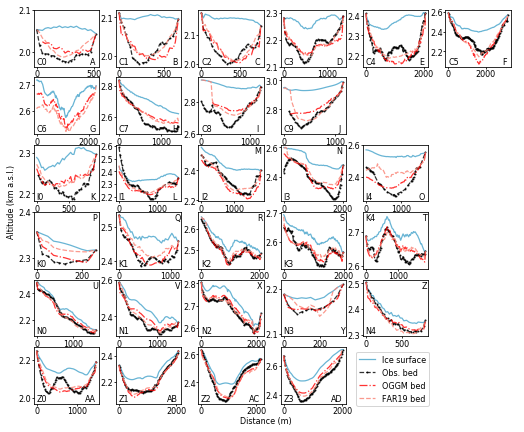

In [290]:
## ALL glaciers
## Conrad 10 gates, 11 bins, Illec. 5 gates 6 bins, Kokanee 5 gates 6 bins

Glacier = ['Kokanee', 'Conrad', 'Illecillewaet', 'Nordic','Zillmer']
glacier = ['kokanee', 'conrad', 'illecillewaet', 'nordic', 'zillmer']
import pickle
with open('/home/pelto/Desktop/ice_flux/Illecillewaet/' + glacier[2] +'_df_agg.pkl', 'rb') as f:
    df_agg_Illec = pickle.load(f)
with open('/home/pelto/Desktop/ice_flux/Kokanee/' + glacier[0] +'_df_agg.pkl', 'rb') as f:
    df_agg_Kok = pickle.load(f)
with open('/home/pelto/Desktop/ice_flux/Nordic/2016_D.pkl', 'rb') as f:
    df_agg_nord = pickle.load(f)
with open('/home/pelto/Desktop/ice_flux/Zillmer/zillmer_2016_D.pkl', 'rb') as f:
    df_agg_zill = pickle.load(f)

font = {'family' : 'Helvetica', 'weight' : 'normal',  'size'   : 8}
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1.'
pylab.rcParams['ytick.major.pad']='1.'

j,k = 0,0; n=0; l=1.25
# K['area_opt'] = K.thick_opt * 10 
a=0.8
letter=['A','B','C','D','E', 'F', 'G', 'H', 'I', 'J', ' ',' ','K','L', 'M', 'N', 'O', ' ','P', 'Q', 'R',
        'S', 'T', ' ', 'U','V', 'X', 'Y', 'Z',' ','AA','AB','AC','AD',' ']
gate=['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9',' ', ' ', 'I0','I1','I2','I3','I4',' ', 
      'K0', 'K1', 'K2', 'K3', 'K4',' ', 'N0', 'N1', 'N2', 'N3', 'N4', ' ', 'Z0', 'Z1', 'Z2', 'Z3', ' ', ' ',]
div = 1000 # to make y axis km instead of m use 1000, else 1 

#Conrad data
obs_H = D.copy(); obs_H.gpr[obs_H.len==0.0]=np.nan;obs_H = obs_H.dropna(subset=['gpr'])  #, inplace=True)  

fig, ax = plt.subplots(6,6, figsize=(cm2inch(18, 15)))

for i in range(D.ID.nunique()+8+5+6+6):
    
    if n<12:
        K=D_all[D_all.ID==i].sort_values(by=['distance'])
        O=obs_H[obs_H.ID==i].sort_values(by=['distance'])

        # plot glacier surface
        ax[j,k].tick_params(which='major', length=1.75)
        ax[j,k].plot(K[K.ID==i].distance, (K[K.ID==i].dem/div), color='#43a2ca', alpha=a, label='Ice surf.', lw=l)

        #plot gpr thickness gates
        if n!=6:
            gpr=(O[O.ID==i].dem/div)-(O[O.ID==i].gpr)/div
            gpr_mask=np.isfinite(gpr)
            ax[j,k].plot(O[O.ID==i].distance, gpr, marker='o'
                         , ms=1.0, ls='--', color='k', alpha=a, label='Obs. bed', lw=l)

        ##plot optimized thickness gates
        ax[j,k].plot(K[K.ID==i].distance, (K[K.ID==i].dem/div)-(K[K.ID==i].H_opt/div), 
                     ls='-.', c='r', alpha=a, label='Model bed', lw=l)  #marker='o')

        ##plot Farinotti thickness gates
        ax[j,k].plot(K[K.ID==i].distance, (K[K.ID==i].dem/div)-(K[K.ID==i].farin_corr/div), 
                     ls='--', c='salmon', alpha=a, label='Farinotti bed', lw=l)  #marker='o')
             
        ax[j,k].text(0.04, 0.09, gate[i], transform=ax[j,k].transAxes, verticalalignment='center', horizontalalignment='left')
            
        if i == 10:
            ax[j,k].text(0.9, 0.9, letter[i], transform=ax[j,k].transAxes, verticalalignment='center', horizontalalignment='center')
        else:
            ax[j,k].text(0.9, 0.09, letter[i], transform=ax[j,k].transAxes, verticalalignment='center', horizontalalignment='center')
        
        if i <5 or i==6:
             ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(100/div))
        else:
             ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(200/div))
       
    #     ax[j,k].text(0.04, 0.04, letter[i], transform=ax[j,k].transAxes, fontweight='bold', fontsize=10, verticalalignment='center', horizontalalignment='center',)
        ax[0,0].set_ylim((1.965, 2.1)); ax[1,2].set_ylim((2.6, 2.95));  ax[1,3].set_ylim((2.63, 3.02))
        ax[2,4].set_ylim((2.25, 2.6)); ax[0,3].set_ylim((2.1, 2.31))
#         ax[0,5].set_xlim((-100, 1450));   ax[1,5].set_xlim((-50, 1300)) ; 
        n += 1;    k += 1
        if n == 6: 
            j += 1; k = 0  
        if n== 12:
            j += 1; k = 0 
    elif n > 11 and n < 18:
#         if n==12:
#             k += 1 
        K=df_agg_Illec[df_agg_Illec.id==i-12].sort_values(by=['distance'])
        obs_H = df_agg_Illec.copy();obs_H = obs_H.dropna(subset=['gpr']) 
        O=obs_H[obs_H.id==i-12].sort_values(by=['distance'])

        # plot glacier surface
        ax[j,k].tick_params(which='major', length=1.75)
        ax[j,k].plot(K.distance, (K.dem/div), color='#43a2ca', alpha=a, label='Ice surface', lw=l,)

        #plot gpr thickness gates
        gpr=(O.dem/div)-(O.gpr/div)
        gpr_mask=np.isfinite(gpr)
        ax[j,k].plot(O.distance, gpr, marker='o'
                     , ms=1.0, ls='--', color='k', alpha=a, label='Observed bed', lw=l)

    #         ax[j,k].set_ylim(((df_agg.elev[df_agg.id_opt==i])-(df_agg[df_agg.id_opt==i].thick_opt)+5).max(), -5)

        ##plot optimized thickness gates

        ax[j,k].plot(K.distance, (K.dem/div)-(K.H_opt/div), 
                     ls='-.', c='r', alpha=a, label='OGGM bed', lw=l)  #marker='o')

        ##plot Farinotti thickness gates
        ax[j,k].plot(K.distance, (K.dem/div)-(K.farin_corr/div), 
                     ls='--', c='salmon', alpha=a, label='Farinotti et al. (2019) bed', lw=l)  #marker='o')
#         ax[2,4].set_ylim(2.1, 2.22)
        if i <= 13:
            ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(100/div))
        else:
            ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(200/div))
        #ax[j,k].set_facecolor('0.92') ## make grey background for Illec.

        ax[j,k].text(0.04, 0.09, gate[i], transform=ax[j,k].transAxes, verticalalignment='center', horizontalalignment='left')
        
        
        if i == 14 or i==15:
            ax[j,k].text(0.9, 0.9, letter[i], transform=ax[j,k].transAxes, verticalalignment='center', horizontalalignment='center')
        else:
            ax[j,k].text(0.9, 0.09, letter[i], transform=ax[j,k].transAxes, verticalalignment='center', horizontalalignment='center')
          
        n += 1;    k += 1
        if n == 18: 
            j += 1; k = 0  
    elif n > 17 and n < 24: 
        K=df_agg_Kok[df_agg_Kok.id==i-18].sort_values(by=['distance'])
        obs_H = df_agg_Kok.copy();obs_H = obs_H.dropna(subset=['gpr']) 
        O=obs_H[obs_H.id==i-18].sort_values(by=['distance'])

        # plot glacier surface
        ax[j,k].tick_params(which='major', length=1.75)
        ax[j,k].plot(K.distance, (K.dem/div), color='#43a2ca', alpha=a, label='Ice surface',lw=l)

        #plot gpr thickness gates
        gpr=(O.dem/div)-(O.gpr/div)
        gpr_mask=np.isfinite(gpr)
        ax[j,k].plot(O.distance, gpr, marker='o', ms=1.0, ls='--', color='k', alpha=a, label='Obs. bed', lw=l)

        ##plot optimized thickness gates
        ax[j,k].plot(K.distance, (K.dem/div)-(K.H_opt/div), ls='-.', c='r', alpha=a, label='OGGM bed',lw=l)  #marker='o')

        ##plot Farinotti thickness gates
        ax[j,k].plot(K.distance, (K.dem/div)-(K.farin_corr/div), 
                     ls='--', c='salmon', alpha=a, label='FAR19 bed', lw=l)  #marker='o')

        ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(100/div)) ##
       
        ax[3,0].set_ylim(2275/div, 2400/div);ax[3,2].set_ylim(2410/div, 2680/div);ax[3,4].set_ylim((2.59, 2.76))
#         ax[3,3].set_xlim(1000, 1500);ax[3].set_ylim(2510/div, 2710/div) ax[4].set_ylim(2590/div, 2750/div)

        ax[j,k].text(0.9, 0.9, letter[i], transform=ax[j,k].transAxes, verticalalignment='center', horizontalalignment='left')
        if i == 22:
            ax[j,k].text(0.04, 0.9, gate[i], transform=ax[j,k].transAxes, verticalalignment='center', horizontalalignment='left',)
        else:
            ax[j,k].text(0.04, 0.09, gate[i], transform=ax[j,k].transAxes, verticalalignment='center', horizontalalignment='left')
        n += 1;    k += 1
        if n == 24: 
            j += 1; k = 0 
    elif n > 23 and n < 30: 
        K=df_agg_nord[df_agg_nord.id==i-24].sort_values(by=['distance'])
        obs_H = df_agg_nord.copy();obs_H = obs_H.dropna(subset=['gpr']) 
        O=obs_H[obs_H.id==i-24].sort_values(by=['distance'])

        # plot glacier surface
        ax[j,k].tick_params(which='major', length=1.75)
        ax[j,k].plot(K.distance, (K.dem/div), color='#43a2ca', alpha=a, label='Ice surface',lw=l)

        #plot gpr thickness gates
        gpr=(O.dem/div)-(O.gpr/div)
        gpr_mask=np.isfinite(gpr)
        ax[j,k].plot(O.distance, gpr, marker='o', ms=1.0, ls='--', color='k', alpha=a, label='Obs. bed', lw=l)

        ##plot optimized thickness gates
        ax[j,k].plot(K.distance, (K.dem/div)-(K.H_opt/div), ls='-.', c='r', alpha=a, label='OGGM bed',lw=l)  #marker='o')

        ##plot Farinotti thickness gates
        ax[j,k].plot(K.distance, (K.dem/div)-(K.farin_corr/div), 
                     ls='--', c='salmon', alpha=a, label='FAR19 bed', lw=l)  #marker='o')
        if n == 27:
            ax[j,k].text(0.9, 0.09, letter[i], transform=ax[j,k].transAxes, verticalalignment='center', horizontalalignment='left')
        else:
            ax[j,k].text(0.9, 0.9, letter[i], transform=ax[j,k].transAxes, verticalalignment='center', horizontalalignment='left')
        ax[j,k].text(0.04, 0.09, gate[i], transform=ax[j,k].transAxes, verticalalignment='center', horizontalalignment='left')
        ax[4,1].yaxis.set_major_locator(ticker.MultipleLocator(200/div));ax[4,3].yaxis.set_major_locator(ticker.MultipleLocator(100/div))                                            
        ax[4,3].set_ylim((2.095, 2.22));
        n += 1;    k += 1
        if n == 30: 
            j += 1; k = 0 
    elif n > 29 and n < 36: 
        K=df_agg_zill[df_agg_zill.id==i-30].sort_values(by=['distance'])
        obs_H = df_agg_zill.copy();obs_H = obs_H.dropna(subset=['gpr']) 
        O=obs_H[obs_H.id==i-30].sort_values(by=['distance'])

        # plot glacier surface
        ax[j,k].tick_params(which='major', length=1.75)
        ax[j,k].plot(K.distance, (K.dem/div), color='#43a2ca', alpha=a, label='Ice surface',lw=l)

        #plot gpr thickness gates
        gpr=(O.dem/div)-(O.gpr/div)
        gpr_mask=np.isfinite(gpr)
        ax[j,k].plot(O.distance, gpr, marker='o', ms=1.0, ls='--', color='k', alpha=a, label='Obs. bed', lw=l)

        ##plot optimized thickness gates
        ax[j,k].plot(K.distance, (K.dem/div)-(K.H_opt/div), ls='-.', c='r', alpha=a, label='OGGM bed',lw=l)  #marker='o')

        ##plot Farinotti thickness gates
        ax[j,k].plot(K.distance, (K.dem/div)-(K.farin_corr/div), 
                     ls='--', c='salmon', alpha=a, label='FAR19 bed', lw=l)  #marker='o')
        ax[j,k].text(0.95, 0.09, letter[i], transform=ax[j,k].transAxes, verticalalignment='center', horizontalalignment='right')
        ax[j,k].text(0.04, 0.09, gate[i], transform=ax[j,k].transAxes, verticalalignment='center', horizontalalignment='left')
        ax[5,0].set_ylim((1.97, 2.27));ax[5,1].set_ylim((2.03, 2.47))  
        n += 1;    k += 1
        
        
ax[5,4].legend(bbox_to_anchor=(1.07, 0.99))
ax[1,5].axis('off');ax[1,4].axis('off');ax[3,5].axis('off');ax[3,5].axis('off');ax[2,5].axis('off');ax[4,5].axis('off')
ax[5,4].axis('off');ax[5,5].axis('off')
# plt.axhspan(0.75, i+.2, facecolor='0.2', alpha=0.5)
fig.text(0.003, 0.6, 'Altitude (km a.s.l.)', rotation=90)
fig.text(0.46, 0.009, 'Distance (m)')     
fig.subplots_adjust(bottom=0.054, top=0.98, left=0.055, right=0.99, wspace=0.26, hspace=0.19) 

plt.savefig(fl_path + 'products/' +'All_gates_all_glaciers_5_NEW.pdf', dpi=300)     

In [ ]:
df_agg_nord

In [ ]:
gates.sort_values(by='ID',ascending=True, inplace=True) # sort by bin

WID =[]
for i in range(len(gates.ID)):
    W1=gates[gates.ID == i].len.to_numpy()
    W2=gates[gates.ID == i+1].len.to_numpy()
    WID.append(1-(W1/W2))   #,ignore_index=True)
gates['p_len_diff']= WID

gates

In [ ]:
sVSTAKE=1.10; sVOFFice=1.8; sVCoreg=3.0; sVRAND=2.0
sVsys=np.sqrt((sVSTAKE**2)+(sVOFFice**2))


In [ ]:
len(df_agg),len(df_agg.gpr.npis

In [ ]:
df_agg

In [ ]:
year=2017

vf_list = ['conrad_2016_vy_25m_pos.tif','conrad_2017_vy_25m_pos.tif','conrad_2018_vy_25m_pos_17mos.tif']
vdir = '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/'
ITS = fl_path + 'ITS_Live/' + str(year) + '_conrad_ITS_LIVE.tif'
I = np.abs(year - 2016) 
### for 2016/7
if I == 2:
    VX = vdir+ vf_list[I][:-20] + 'vx_25m.tif'
    VY = vdir+ vf_list[I]
    VM = vdir+ vf_list[I][:-20] + 'vm_25m.tif'
else:
    VX = vdir+ vf_list[I][:-14] + 'vx_25m.tif' 
    VY = vdir+ vf_list[I]
    VM = vdir+ vf_list[I][:-14] + 'vm_25m.tif'


vy = salem.open_xr_dataset(VY);vy = vy.to_array(name='vy')
vx = salem.open_xr_dataset(VX);vx = vx.to_array(name='vx')

vz = vy
vz.data = np.sqrt(vx.data**2 + vz.data**2 )
vz.data[vz.data<0.01]=np.nan; #vz.data[vz.data>50.0]=np.nan
vz.data[msk_conrad.data!=1.0] = np.nan;

font = {'family' : 'Helvetica', 'weight' : 'normal', 'size'   : 8}
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1'
pylab.rcParams['ytick.major.pad']='1'

fig, ax = plt.subplots(1, figsize=cm2inch(8.5,10.))
topo_big = '/home/pelto/Desktop/lidar_cbt_analysis/conrad/dem_mosaic_conrad.tif'
grid1 = mercator_grid(center_ll=(-116.92, 50.802), extent=(4700, 7400)) ##zoomed out view
# 487892.000 5509738.000 491232.000 5512358.000
# grid1 = vx.salem.grid  ##full view
sm1 = Map(grid1, countries=False)
sm1.set_lonlat_contours(interval=0)
sm1.set_scale_bar(location=(0.13, 0.06),add_bbox=True,bbox_dy=1.5,linewidth=1.0)

VZA=xr.DataArray(data=vz, coords=vz.coords, dims=vz.dims, name='VZA', attrs=vz.attrs) #,indexes=vx.indexes fastpath=False)

# VZA.data=VZA.data*(msk+1.0)
sm1.set_data(vz) 

sm1.set_cmap("Spectral_r")
sm1.set_vmax(val=60.)
shape = salem.read_shapefile('/home/pelto/Desktop/lidar_cbt_analysis/conrad/Conrad/conrad_16_extent.shp')
#      Change the lon-lat countour setting
sm1.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
sm1.set_topography(topo_big,  relief_factor=0.8)
sm1.set_shapefile(shape, lw=1.2, color='k')
sm1.set_shapefile(gates, color='w', lw=1.1)

obs_shp = '/home/pelto/Desktop/ice_flux/Flux_pts.csv'
obs_pts = pd.read_csv(obs_shp)  #salem.read_shapefile(obs_shp)
x, y = sm1.grid.transform(obs_pts.lon.values, obs_pts.lat.values)
ax.scatter(x, y, color='k', s=8, facecolor='w',zorder=3)


sm1.append_colorbar(ax=ax, pad=0.1, label='Ice velocity (m yr$^{-1}$)')#, cbar_title='Ice Velocity (m yr$^-1$)')
sm1.plot(ax=ax)

u = D.vx.values;v = D.vy.values
X, Y = np.meshgrid(D.lon,D.lat)

# transform their coordinates to the map reference system and plot the arrows
xx, yy = sm1.grid.transform(D.lon, D.lat, crs=salem.wgs84)#sm1.grid.proj

# xx, yy = np.meshgrid(xx,yy)

# qu = ax.quiver(xx, yy, u, v)

###### start:stop:step
n=1
Q = ax.quiver(xx[::n], yy[::n], u[::n], v[::n], scale=600.)  #, pivot='mid')
qk = ax.quiverkey(Q, 0.07, 0.10, 50, r'$40 \frac{m}{a}$', labelpos='N', coordinates='figure', labelsep=0.025, zorder=1)



# Q = ax.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2], pivot='mid')
#Q= ax2.quiver(X[::3, ::3], Y[::3, ::3], U[::3, ::3], V[::3, ::3],pivot='mid', units='inches')

# X, Y = np.meshgrid(D.lon,D.lat)
# U = D.vx.values
# V = D.vy.values
# U,V = np.meshgrid(U, V)

# # Q = ax.quiver(X, Y, U, V)#units='width', angles='uv') 
# Q = ax.quiver(X[::30, ::30], Y[::30, ::30], U[::30, ::30], V[::30, ::30], units='xy')


fig.subplots_adjust(bottom=0.05, top=0.99, left=0.14, right=0.88) #, wspace=0.22, hspace=0.15
plt.savefig(fl_path+ 'products/conrad_vel_gates_quiver_'+str(year) +'_1.pdf', dpi=300)

In [ ]:
year=2017

vf_list = ['conrad_2016_vy_25m_pos.tif','conrad_2017_vy_25m_pos.tif','conrad_2018_vy_25m_pos_17mos.tif']
vdir = '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/'
ITS = fl_path + 'ITS_Live/' + str(year) + '_conrad_ITS_LIVE.tif'
I = np.abs(year - 2016) 
### for 2016/7
if I == 2:
    VX = vdir+ vf_list[I][:-20] + 'vx_25m.tif'
    VY = vdir+ vf_list[I]
    VM = vdir+ vf_list[I][:-20] + 'vm_25m.tif'
else:
    VX = vdir+ vf_list[I][:-14] + 'vx_25m.tif' 
    VY = vdir+ vf_list[I]
    VM = vdir+ vf_list[I][:-14] + 'vm_25m.tif'


vy = salem.open_xr_dataset(VY);vy = vy.to_array(name='vy')
vx = salem.open_xr_dataset(VX);vx = vx.to_array(name='vx')

vz = vy
vz.data = np.sqrt(vx.data**2 + vz.data**2 )
vz.data[vz.data<0.01]=np.nan; #vz.data[vz.data>50.0]=np.nan
vz.data[msk_conrad.data!=1.0] = np.nan;

firn = '/home/pelto/Desktop/ice_flux/Conrad/AAR_conrad_2012_2018.tif'
firn =salem.open_xr_dataset(firn); firn_reproj = vx.salem.transform(firn);firn = firn_reproj.to_array(name='firn')
firn.data[msk_conrad.data!=1.0] = np.nan;

font = {'family' : 'Helvetica', 'weight' : 'normal', 'size'   : 8}
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1';pylab.rcParams['ytick.major.pad']='1'

fig, ax = plt.subplots(1, figsize=cm2inch(8.5,10.))
topo_big = '/home/pelto/Desktop/lidar_cbt_analysis/conrad/dem_mosaic_conrad.tif'
grid1 = mercator_grid(center_ll=(-116.92, 50.802), extent=(4700, 7400)) ##zoomed out view
# 487892.000 5509738.000 491232.000 5512358.000
# grid1 = vx.salem.grid  ##full view
sm1 = Map(grid1, countries=False)
sm1.set_lonlat_contours(interval=0)
sm1.set_scale_bar(location=(0.13, 0.06),add_bbox=True,bbox_dy=1.5,linewidth=1.0)

# VZA.data=VZA.data*(msk+1.0)
sm1.set_data(firn) 

sm1.set_cmap("Blues")
# sm1.set_vmax(val=60.)
shape = salem.read_shapefile('/home/pelto/Desktop/lidar_cbt_analysis/conrad/Conrad/conrad_16_extent.shp')
#      Change the lon-lat countour setting
sm1.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
sm1.set_topography(topo_big,  relief_factor=0.8)
sm1.set_shapefile(shape, lw=1.2, color='k')
sm1.set_shapefile(gates, color='w', lw=1.1)

obs_shp = '/home/pelto/Desktop/ice_flux/Flux_pts.csv'
obs_pts = pd.read_csv(obs_shp)  #salem.read_shapefile(obs_shp)
x, y = sm1.grid.transform(obs_pts.lon.values, obs_pts.lat.values)
ax.scatter(x, y, color='k', s=8, facecolor='w',zorder=3)


sm1.append_colorbar(ax=ax, pad=0.1, label='Firn cover (years)')#, cbar_title='Ice Velocity (m yr$^-1$)')
sm1.plot(ax=ax)


fig.subplots_adjust(bottom=0.05, top=0.99, left=0.14, right=0.88) #, wspace=0.22, hspace=0.15
plt.savefig(fl_path+ 'products/conrad_firn_map.pdf', dpi=300)

In [4]:
#### number of days average velocity
conrad_vel_days = [363,366,399,370,340,352]
illec_vel_days = [364,367,399,357,377,370,340,394,339]
kok_vel_days = [364,367,399,340,326]
n_vds =[364,367,399,366,340,382]
z_vds=[365,347,397,366,374,331]
np.mean(conrad_vel_days + illec_vel_days + kok_vel_days + n_vds+z_vds), np.std((conrad_vel_days + illec_vel_days + kok_vel_days+ n_vds+z_vds))

(365.34375, 20.525303552871026)

In [5]:
#### number of cover average velocity
conrad_vel_cover = [95,84,98,71,97,96]
illec_vel_cover = [80,86,86,79,71,94,97,92,79]
kok_vel_cover = [87,87,97,97,85]
n_vc=[74,80,81,95,99,98]
z_vc=[96,98,97,98,97,98]
np.mean(conrad_vel_cover + illec_vel_cover + kok_vel_cover+n_vc+z_vc), np.std((conrad_vel_cover + illec_vel_cover + kok_vel_cover+n_vc+z_vc))

(89.65625, 8.741457883985943)